
---


The Business Case is 2-fold :

1. Segmentation: 

- Identify new user segmentation opportunities based on *__behavior data__* and your understanding of *__business challenges__* ;
- propose an approach to test the relevance of the segmentation 
- and how to implement it in the product


1. Plan To Improve
- Present a plan to improve (on your opinion) player matchmaking (= how Blitz decides who plays against whom),
- from proposing algorithm improvements to testing and implementing in the product


Instruction :

Deadline : 1 week

Format : 3 pages memo on Google Doc

---
---
# Segmenation tool - start
---

### Objective Assumption:
#### Our objective is to be able to segment users so that we can improve profit by seeing what behaviours relate paying users (payers) from non-paying users (non-payers). 


---

# Agenda:

Start Data Treatement
1. Load Data + quality check 
1. Exploratory Data Analysis (EDA)
1. Feature Engineering
1. Pre-processing

Start ML PIPELINE
1. Model Creation-Training
1. Evaluation
1. Results


---
---

# Imports

In [1]:
# Main imports
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# Secondary Imports
import matplotlib.ticker as ticker
import polars.selectors as cs

In [2]:
#own functions
from visualizations import histo


In [3]:
pl.Config.set_tbl_cols(200)  
pl.Config.set_tbl_rows(10)

polars.config.Config

> Given the size of data  Polars librerary will be a better suit instead of Pandas.

# ---- Start Data Treatement ----

# 1) Load Data

In [4]:
df = pl.read_parquet("Copy of Copy of blitz_case_study.parquet")
df.head(3)


user_id,game_id,match_type,entry_credit_type,entry_price_dollars,entry_price_coins,prize_dollars,prize_coins,started_at,total_players,match_rank,seconds_until_result
str,str,str,str,"decimal[25,4]",i64,f64,i32,datetime[ns],i32,i64,i64
"""grljjnB0W3TeQF4zbmYSgK8fje73""","""Domino""","""BRAWL""","""DOLLAR""",0.6000,300,0.0,null,2023-12-01 06:16:42,5,4,1256
"""i1bSrM2dhIQdnKkKRSi3SBF9PMS2""","""21Blitz""","""BRAWL""","""COIN""",null,50,null,120,2023-12-01 06:16:51,5,1,7753
"""ycv5gjeeA0OuzoSsToa2WEkYn3z2""","""Match3""","""BRAWL""","""COIN""",null,50,null,0,2023-12-01 06:16:58,5,4,109


### Formating
Cast columns to the right format

In [5]:
df = df.with_columns([
    pl.col('entry_price_dollars').cast(pl.Float64), 
])
df.head(3)

user_id,game_id,match_type,entry_credit_type,entry_price_dollars,entry_price_coins,prize_dollars,prize_coins,started_at,total_players,match_rank,seconds_until_result
str,str,str,str,f64,i64,f64,i32,datetime[ns],i32,i64,i64
"""grljjnB0W3TeQF4zbmYSgK8fje73""","""Domino""","""BRAWL""","""DOLLAR""",0.6,300,0.0,null,2023-12-01 06:16:42,5,4,1256
"""i1bSrM2dhIQdnKkKRSi3SBF9PMS2""","""21Blitz""","""BRAWL""","""COIN""",null,50,null,120,2023-12-01 06:16:51,5,1,7753
"""ycv5gjeeA0OuzoSsToa2WEkYn3z2""","""Match3""","""BRAWL""","""COIN""",null,50,null,0,2023-12-01 06:16:58,5,4,109


---
# 2)  EDA

In [6]:
df.head(5)

user_id,game_id,match_type,entry_credit_type,entry_price_dollars,entry_price_coins,prize_dollars,prize_coins,started_at,total_players,match_rank,seconds_until_result
str,str,str,str,f64,i64,f64,i32,datetime[ns],i32,i64,i64
"""grljjnB0W3TeQF4zbmYSgK8fje73""","""Domino""","""BRAWL""","""DOLLAR""",0.6,300,0.0,null,2023-12-01 06:16:42,5,4,1256
"""i1bSrM2dhIQdnKkKRSi3SBF9PMS2""","""21Blitz""","""BRAWL""","""COIN""",null,50,null,120,2023-12-01 06:16:51,5,1,7753
"""ycv5gjeeA0OuzoSsToa2WEkYn3z2""","""Match3""","""BRAWL""","""COIN""",null,50,null,0,2023-12-01 06:16:58,5,4,109
"""TsjC0GcG20cnZh8kQr2vEKn390g2""","""Bingo""","""BRAWL""","""COIN""",null,120,null,160,2023-12-01 06:17:07,5,2,554
"""rnnyg31NzHWxpQNVt4O4TKwuHEn2""","""BallBlast""","""BRAWL""","""COIN""",null,50,null,30,2023-12-01 06:17:15,5,3,1074


In [7]:
categorical_cols = ["user_id","game_id","match_type","entry_credit_type"]
numerical_cols = ["entry_price_dollars","entry_price_coins","prize_dollars","prize_coins","total_players","match_rank","seconds_until_result"]
temporal_cols = ["started_at"]
target = None

#not missing any col, assert should be true
assert len(categorical_cols + numerical_cols + temporal_cols) == len( df.columns), 'There are missing cols'

In [8]:
#Quick look
for col in df.columns:
    unique_values = df.select(pl.col(col)).unique().to_series().to_list()
    unique_count = len(unique_values)
    print(col, "_"*(30-len(col)), " : unique count=> ", unique_count, " "*(7- int(len(str(unique_count)))),"| examples:", unique_values[:10])

user_id _______________________  : unique count=>  158009   | examples: ['goypr3SdACdJHV7TpeI3ikCPcnd2', 'cRGbFg2nUudvFmMHgslDOrZtT172', 'O7iz6gUFQvP7V6A44wa5WmL1YYC2', 'JKdrwzpYaUXC3Sx0H0i9ejMI5PR2', 'KwjEGz5iXTc2spIMCfvjIHtEfO12', 'ZczuM6DsAqXF3C8Vw8sitezSmzj1', 'LMHVKgd4EBTFDJGP5hfIyOubNMI2', 'c12gWV14qFWlApF6kOM6JIDBYvp1', '4BhOuIDqg6fC63wyIdhRYSYUAN32', 'tfrM1nxrL5eQ4HEK0qUvMeUpjMa2']
game_id _______________________  : unique count=>  17       | examples: ['Bingo', 'Match3', 'TripeaksSolitaire', 'FindObjects', 'TileMatch', 'WheelOfFortune', 'BubbleShooter', 'Domino', 'KlondikeSolitaire', 'Golf']
match_type ____________________  : unique count=>  3        | examples: ['ONE_VS_ONE', 'BRAWL', 'SPIN_AND_GO']
entry_credit_type _____________  : unique count=>  2        | examples: ['DOLLAR', 'COIN']
entry_price_dollars ___________  : unique count=>  82       | examples: [3.0, 9.0, 22.0, 0.7, None, 1.3, 25.0, 0.3, 65.0, 53.0]
entry_price_coins _____________  : unique count=>  12       | 

### Duplicates

In [9]:
df.filter(df.is_duplicated()).height

0

### Missing Values

In [10]:
for col in df.columns:
  print(f"{col} = {df[col].null_count()}")

user_id = 0
game_id = 0
match_type = 0
entry_credit_type = 0
entry_price_dollars = 10858070
entry_price_coins = 3656449
prize_dollars = 10780824
prize_coins = 4292238
started_at = 0
total_players = 0
match_rank = 0
seconds_until_result = 0


> No missing values

> No Duplicates

> The quality of the data seems to be ok.

### Adhoc Questions

In [11]:
# Masks

dollar_type = df['entry_credit_type'] == "DOLLAR"
coin_type = df['entry_credit_type'] == "COIN"

coin_entry = ~df['entry_price_coins'].is_null() # coin_entry_nul
coin_outcome = ~df['prize_coins'].is_null() # coin_prix_nul

dollar_entry = ~df['entry_price_dollars'].is_null() # coin_entry_nul
dollar_outcome = ~df['prize_dollars'].is_null() # coin_prix_nul

In [12]:
#Could there be a user  with NO coin entry and  prize coins?  -> YES,  dollar based
df.filter(~coin_entry &  ~coin_outcome ).head(2)
#df.filter(~coin_entry &  ~coin_outcome & coin_type).head(2) --> zero results, must have dollars


user_id,game_id,match_type,entry_credit_type,entry_price_dollars,entry_price_coins,prize_dollars,prize_coins,started_at,total_players,match_rank,seconds_until_result
str,str,str,str,f64,i64,f64,i32,datetime[ns],i32,i64,i64
"""7DrKxjFc3jUwz2YZAlh2EfS52Op2""","""Match3""","""BRAWL""","""DOLLAR""",0.5,null,1.3,null,2023-12-01 06:17:39,5,2,144
"""OiWrYu1lPEfgJtcGlFg6kGMwmay2""","""Pool""","""BRAWL""","""DOLLAR""",1.0,null,1.3,null,2023-12-01 06:20:18,5,2,615


In [13]:
#Could there be a user entry with NO Dollar entry and  Dollar Prize ?  -> Yes (coin based)
df.filter(~dollar_entry & dollar_outcome ).head(3)

user_id,game_id,match_type,entry_credit_type,entry_price_dollars,entry_price_coins,prize_dollars,prize_coins,started_at,total_players,match_rank,seconds_until_result
str,str,str,str,f64,i64,f64,i32,datetime[ns],i32,i64,i64
"""xT6TEDNOPlSFh80uzJG96zAhpEt2""","""Bingo""","""BRAWL""","""COIN""",null,1000,1.0,null,2023-12-01 06:25:26,10,1,316
"""i9dYe2n94JMihwzwwSWYoPHbyL83""","""KlondikeSolitaire""","""BRAWL""","""COIN""",null,1000,0.6,null,2023-12-01 06:26:53,10,2,128
"""GAPAV5yPO3VUaPhQViZYSem4jN32""","""GridBlocks""","""BRAWL""","""COIN""",null,1000,0.6,null,2023-12-01 06:27:36,10,2,129


In [14]:
df.filter(~dollar_entry & dollar_outcome )['match_type'].unique()

match_type
str
"""BRAWL"""


> So the company can have a loss, in the exchange of coins for dollars

## Variables 

### Temporal

#### Started_at 

In [15]:
df['started_at'].min(), df['started_at'].max(),

(datetime.datetime(2023, 12, 1, 0, 0),
 datetime.datetime(2023, 12, 31, 23, 59, 59))

### Categorical

#### User_id

In [16]:
print(f"unique users = {df['user_id'].n_unique()},  total rows = { df['user_id'].len()}")

unique users = 158009,  total rows = 15073046


In [17]:
df['user_id'].n_unique()/df['user_id'].len() * 100

1.0482884481345045

In [18]:
af = df.group_by('user_id').len().rename({"len": "games_played"})
af2 = af.group_by('games_played').len().rename({"len":'users'}).sort(by='users', descending = True)
total_users = af2['users'].sum()
af2 = af2.with_columns(
    (pl.col("users") / total_users * 100).round(3).alias("%_total")
)
af2 = af2.with_columns(
    (pl.col("users").cum_sum() / total_users * 100).round(2).alias("cumul_percent")
)

af2.head(5)

games_played,users,%_total,cumul_percent
u32,u32,f64,f64
1,18654,11.806,11.81
2,11764,7.445,19.25
3,8736,5.529,24.78
4,6955,4.402,29.18
5,5421,3.431,32.61


<Axes: >

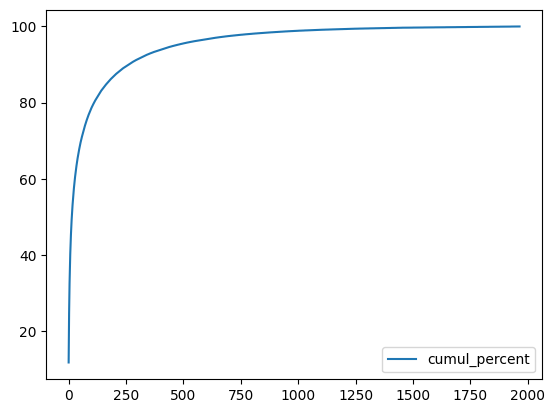

In [19]:
af2.select('cumul_percent').to_pandas().plot()

<Axes: >

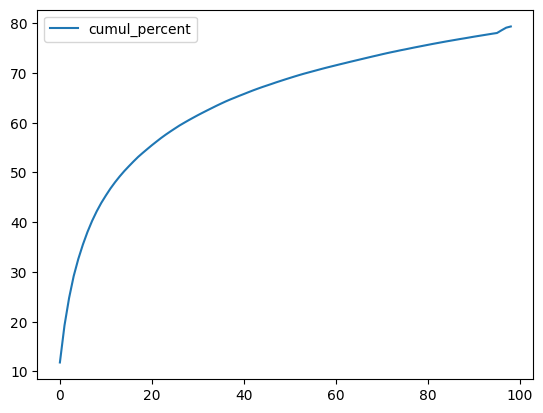

In [20]:
af2.filter(af2['games_played']< 100).select('cumul_percent').to_pandas().plot()

> Almost 1/4th of users dont play more than 3 games and 50% dont play more than 15 games 

> --> This could be due to the data size, the last arrivals dont have time enought to play more.


#### Game_id

In [21]:
df['game_id'].unique().len()

17

In [22]:
df.group_by('game_id').len().to_pandas()

,game_id,len
0,BallBlast,382282
1,GinRummy,270423
2,BubbleShooter,1070500
3,GridBlocks,1700750
4,PokerBlast,320752
5,Golf,111092
6,FindObjects,6038
7,KlondikeSolitaire,3968721
8,Pool,969126
9,TileMatch,124


c:\00 ALL\04 Jobs\22 Voodoo\visualizations.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col_name, y='count', data=df, palette='viridis')


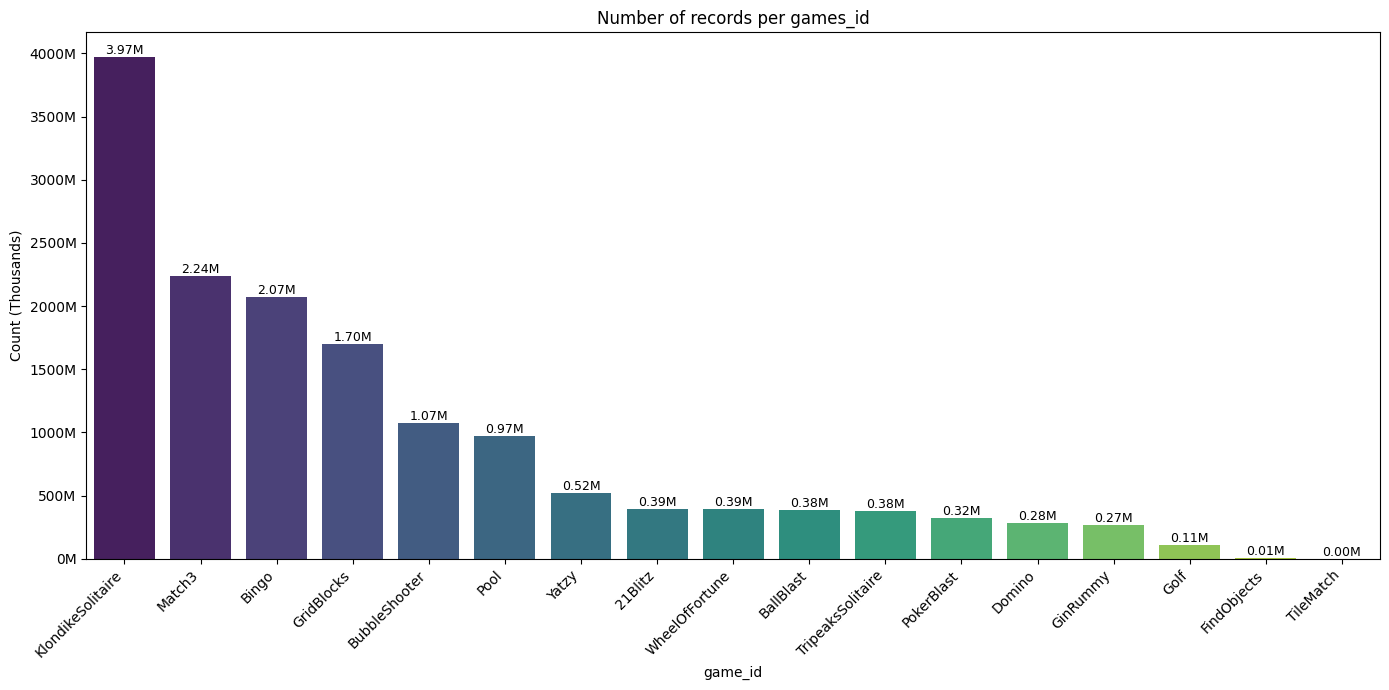

In [23]:
game_counts = df.group_by('game_id').len().to_pandas()
histo(game_counts,'game_id', title='Number of records per games_id',symbol='M')

c:\00 ALL\04 Jobs\22 Voodoo\visualizations.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col_name, y='count', data=df, palette='viridis')


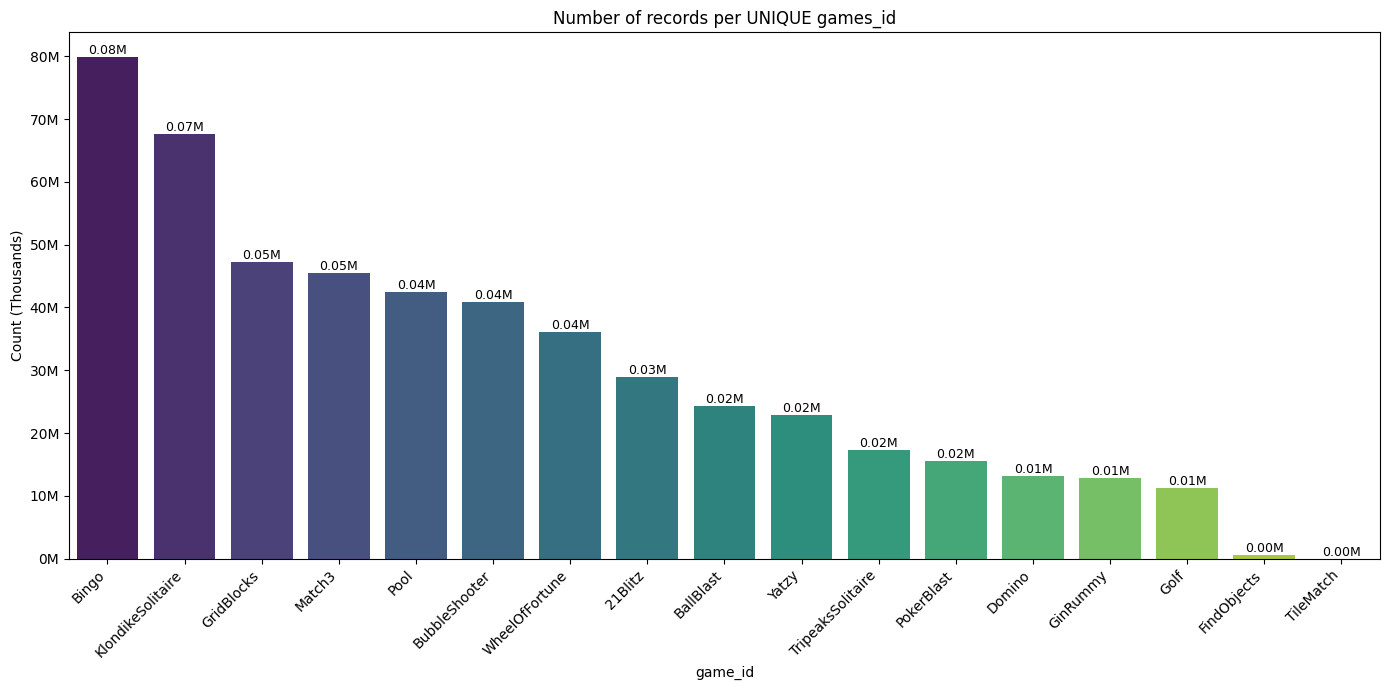

In [24]:
game_counts = df.group_by(['game_id']).agg(pl.n_unique('user_id').alias('count')).to_pandas()
histo(game_counts,'game_id', title='Number of records per UNIQUE games_id',symbol='M')

#### Match_type 

c:\00 ALL\04 Jobs\22 Voodoo\visualizations.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col_name, y='count', data=df, palette='viridis')


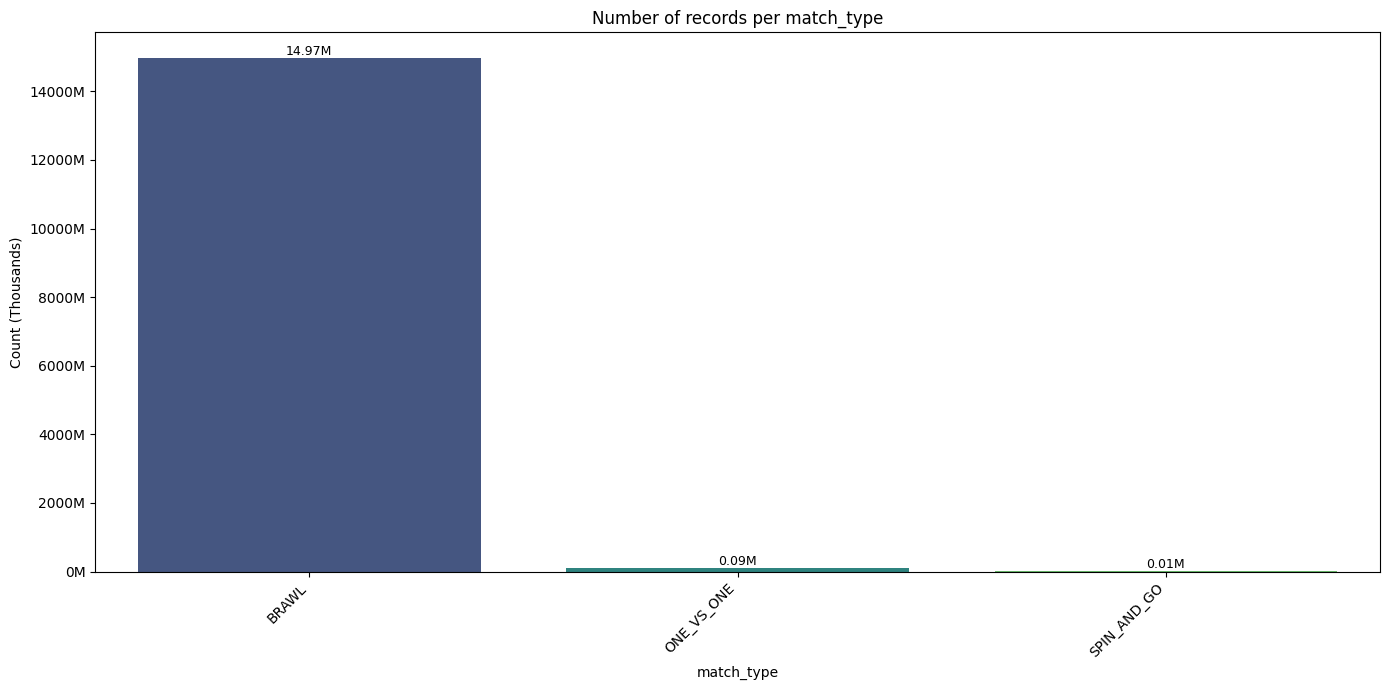

In [25]:
game_counts = df.group_by('match_type').len().to_pandas()
histo(game_counts,'match_type', title='Number of records per match_type',symbol='M')

> Clear preference

c:\00 ALL\04 Jobs\22 Voodoo\visualizations.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col_name, y='count', data=df, palette='viridis')


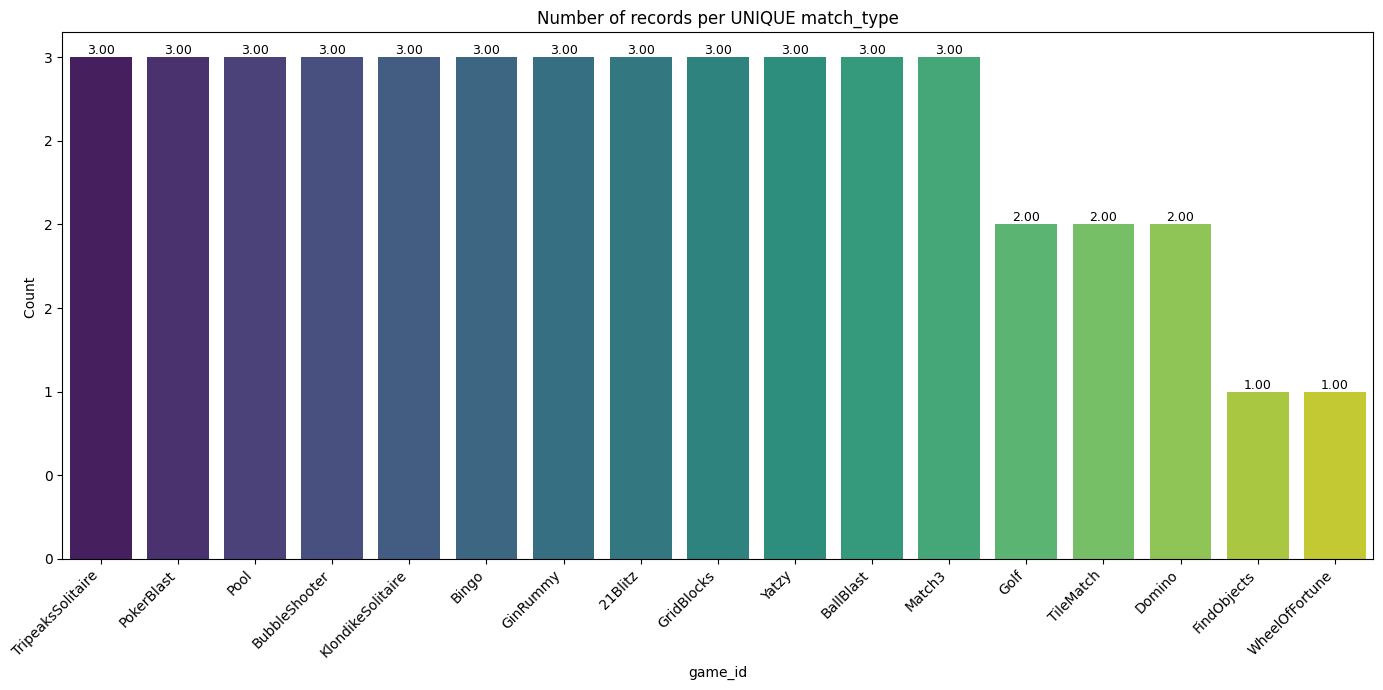

In [26]:
game_counts = df.group_by(['game_id']).agg(pl.n_unique('match_type').alias('count')).to_pandas()
histo(game_counts,'game_id', title='Number of records per UNIQUE match_type',symbol='None' )

> Not all games have all match types

#### Entry_credit_type

c:\00 ALL\04 Jobs\22 Voodoo\visualizations.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col_name, y='count', data=df, palette='viridis')


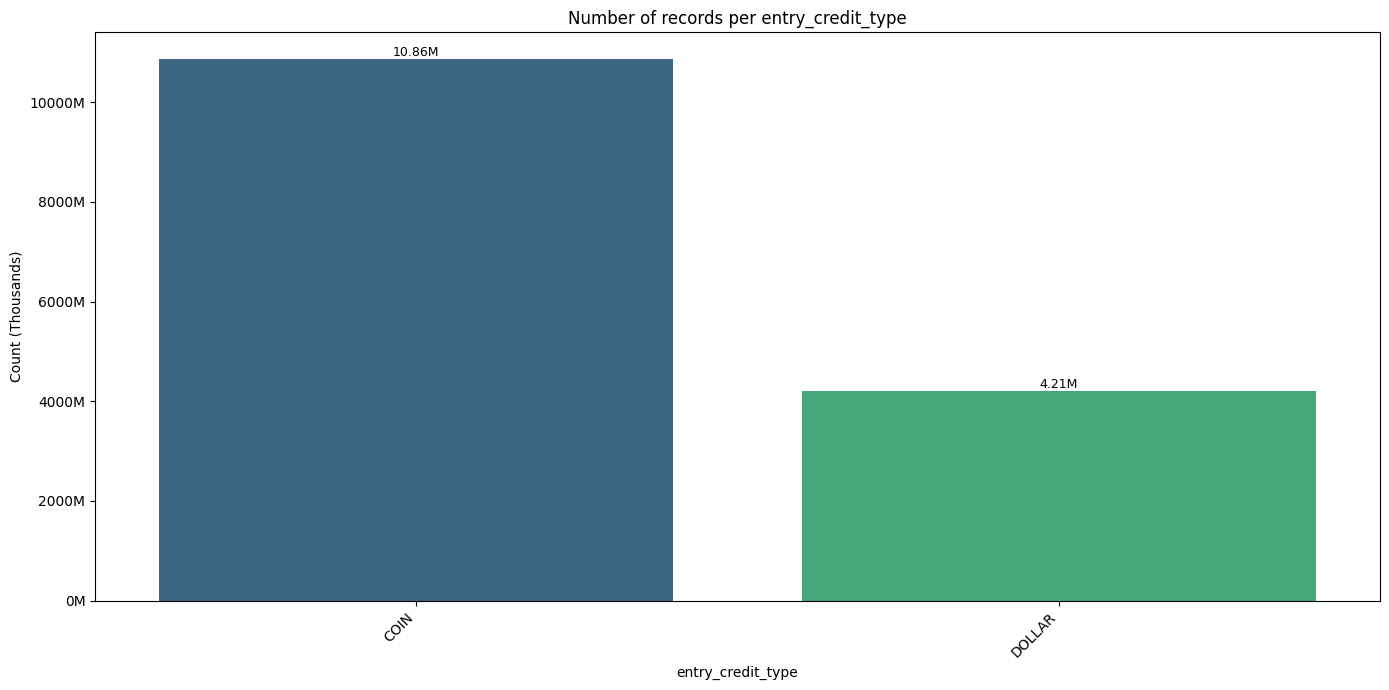

In [27]:
game_counts = df.group_by('entry_credit_type').len().to_pandas()
histo(game_counts,'entry_credit_type', title='Number of records per entry_credit_type',symbol='M')

c:\00 ALL\04 Jobs\22 Voodoo\visualizations.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col_name, y='count', data=df, palette='viridis')


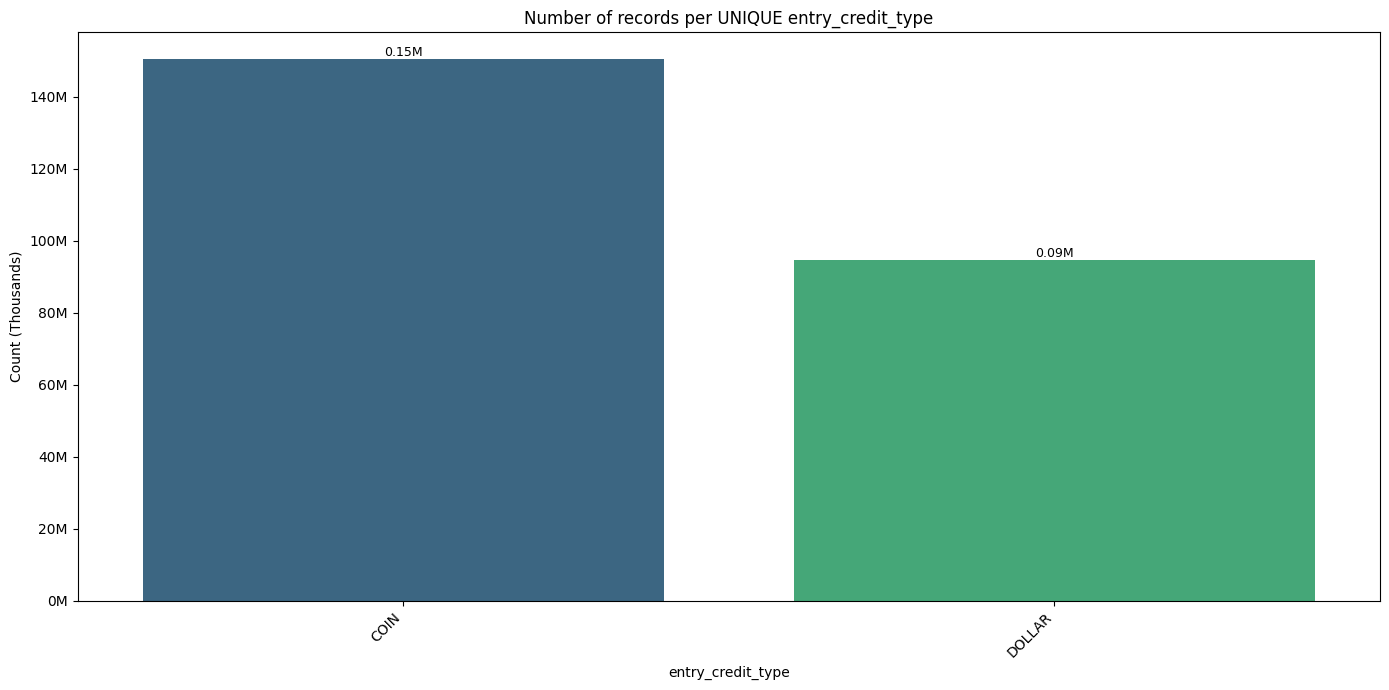

In [28]:
game_counts = df.group_by(['entry_credit_type']).agg(pl.n_unique('user_id').alias('count')).to_pandas()
histo(game_counts,'entry_credit_type', title='Number of records per UNIQUE entry_credit_type',symbol='M')

###  Numerical Variables

In [29]:
df[numerical_cols].describe()

statistic,entry_price_dollars,entry_price_coins,prize_dollars,prize_coins,total_players,match_rank,seconds_until_result
str,f64,f64,f64,f64,f64,f64,f64
"""count""",4.214976e6,1.1416597e7,4.292222e6,1.0780808e7,1.5073046e7,1.5073046e7,1.5073046e7
"""null_count""",1.085807e7,3.656449e6,1.0780824e7,4.292238e6,0.0,0.0,0.0
"""mean""",2.903107,94.448894,2.163375,48.065408,5.10198,3.024772,1064.238591
"""std""",6.570809,168.049672,7.66237,53.486798,0.814014,1.51042,5212.683145
"""min""",0.2,15.0,0.0,0.0,2.0,1.0,5.0
"""25%""",1.0,50.0,0.0,0.0,5.0,2.0,155.0
"""50%""",1.0,50.0,0.5,30.0,5.0,3.0,261.0
"""75%""",3.0,50.0,2.0,70.0,5.0,4.0,516.0
"""max""",150.0,1000.0,225.0,1000.0,10.0,10.0,403657.0


In [30]:
for var in numerical_cols:
    print(var, "= ",df[var].n_unique())

entry_price_dollars =  82
entry_price_coins =  12
prize_dollars =  126
prize_coins =  19
total_players =  3
match_rank =  10
seconds_until_result =  67800


#### Entry_price_dollars

In [31]:
# get the most used entry prices in dollars

af = (df.filter(~df['entry_price_dollars'].is_null())
   .group_by('user_id')
   .agg(pl.col('entry_price_dollars').mode().alias('mode_prices'))
   .explode('mode_prices')
   .rename({'mode_prices': 'entry_price_dollars'}))
af.head(9)

user_id,entry_price_dollars
str,f64
"""jG5pVCnPOoS01gl8trxjeHvr5gI2""",1.0
"""LCZwUelLKnM9RTB9eB4GYMyn2rw2""",1.0
"""uFzOl1sfJ2atFkao58wUT8wlUqg1""",0.2
"""SU99DuwlA3OolkFAnzgdTREl8sH3""",0.6
"""OYmMRaKk6kWcdwf3Hi5KjxATeFk1""",1.0
"""j9TOJYJDcoSv1xzjV3qaWfgonQs2""",1.0
"""j9TOJYJDcoSv1xzjV3qaWfgonQs2""",1.5
"""OXuJTZSdRtdELMedrjKcmZLXaIr2""",0.6
"""OXuJTZSdRtdELMedrjKcmZLXaIr2""",1.0


c:\00 ALL\04 Jobs\22 Voodoo\visualizations.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col_name, y='count', data=df, palette='viridis')


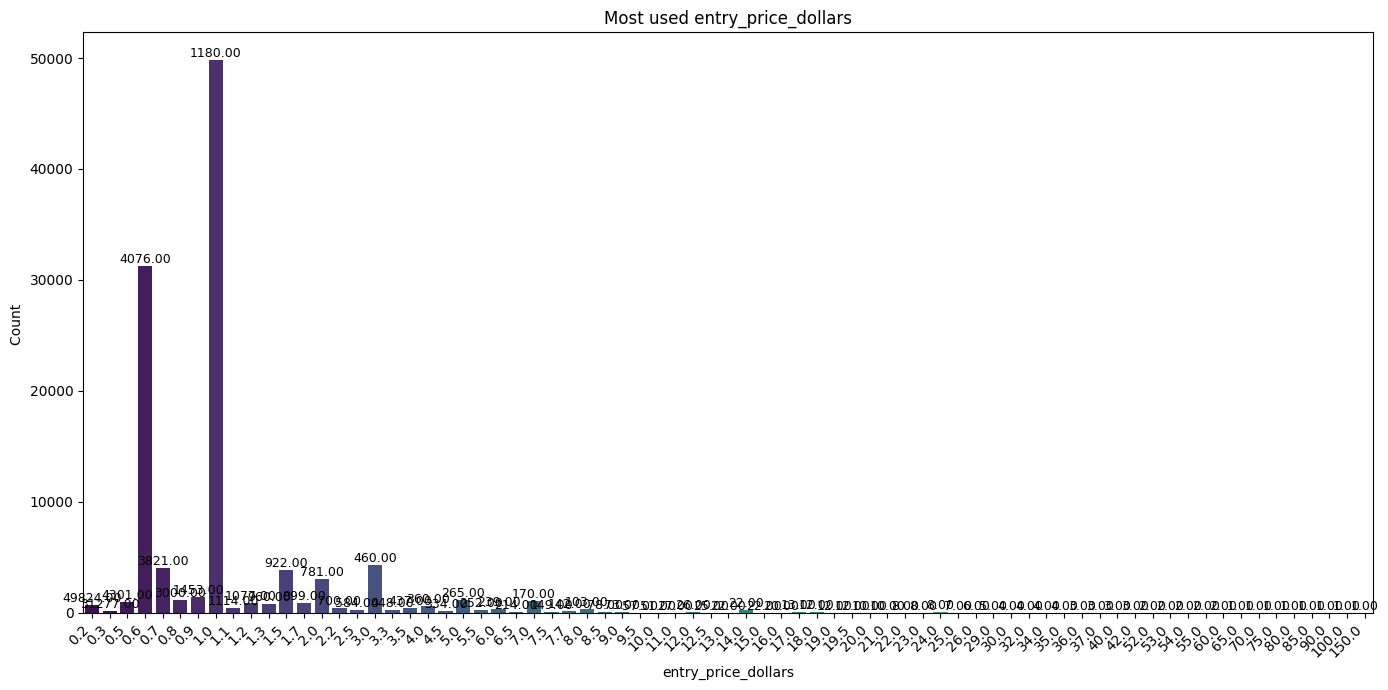

In [32]:
game_counts = af.group_by('entry_price_dollars').len().to_pandas()
histo(game_counts,'entry_price_dollars', title='Most used entry_price_dollars',symbol='D')

c:\00 ALL\04 Jobs\22 Voodoo\visualizations.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col_name, y='count', data=df, palette='viridis')


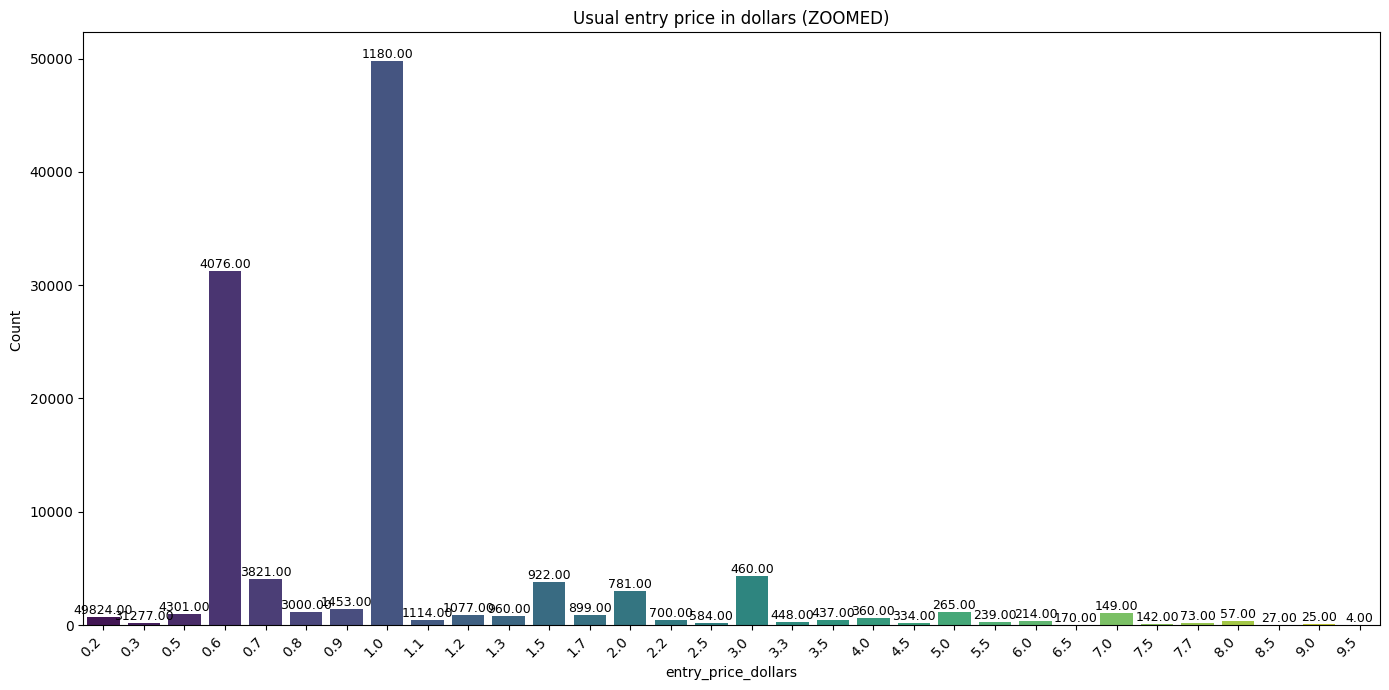

In [33]:
game_counts = af.group_by('entry_price_dollars').len().to_pandas()
game_counts = game_counts[game_counts.entry_price_dollars < 10]
histo(game_counts,'entry_price_dollars', title='Usual entry price in dollars (ZOOMED)',symbol='D')

> The usual betting for majority of users is less than 3 dolars per game.

#### Entry_price_coins

In [34]:
af = (df.filter(~df['entry_price_coins'].is_null())
   .group_by('user_id')
   .agg(pl.col('entry_price_coins').mode().alias('mode_prices'))
   .explode('mode_prices')
   .rename({'mode_prices': 'entry_price_coins'}))
af.head(9)


user_id,entry_price_coins
str,i64
"""BhiaFVxHS7PmfFEzuIwq6wtg1PA2""",1000
"""xv4gWp7q8xUkiECu4r5b0LbkK993""",50
"""DgKBHy4E9xgUq85re6utp5Flyd23""",50
"""Qdt2XLpK4ofEFpjH5XkXJHvErID3""",50
"""AfZgK8ZR8wUYiAnuMqq4K6n9ht72""",50
"""ZcknPWWbJpYan24G4qU50g1C9FT2""",1000
"""NbKQuRu2sXPYvl5ucbrRrRV9kBB2""",50
"""tGNJtFx0UrX7b88h5ZEJiDpBfXi2""",50
"""CN3XoPrWucYi2m2bbXUG3lc9nGw2""",50


c:\00 ALL\04 Jobs\22 Voodoo\visualizations.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col_name, y='count', data=df, palette='viridis')


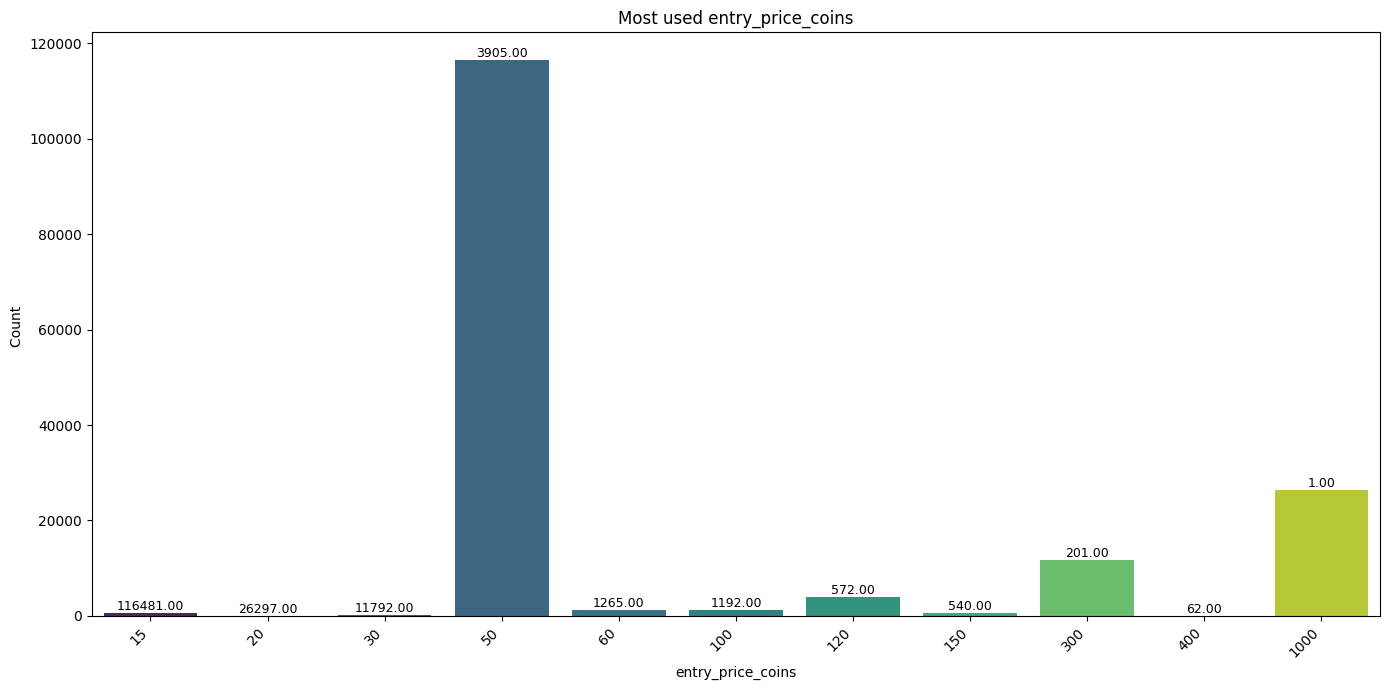

In [35]:
game_counts = af.group_by('entry_price_coins').len().to_pandas()
histo(game_counts,'entry_price_coins', title='Most used entry_price_coins',symbol='D')

#### Prize_dollars 

In [36]:
df.filter(df['prize_dollars']>0).head(4)

user_id,game_id,match_type,entry_credit_type,entry_price_dollars,entry_price_coins,prize_dollars,prize_coins,started_at,total_players,match_rank,seconds_until_result
str,str,str,str,f64,i64,f64,i32,datetime[ns],i32,i64,i64
"""7DrKxjFc3jUwz2YZAlh2EfS52Op2""","""Match3""","""BRAWL""","""DOLLAR""",0.5,null,1.3,null,2023-12-01 06:17:39,5,2,144
"""OiWrYu1lPEfgJtcGlFg6kGMwmay2""","""Pool""","""BRAWL""","""DOLLAR""",1.0,null,1.3,null,2023-12-01 06:20:18,5,2,615
"""mVQEHmXdQGNjfmyimExXMYja86R2""","""Match3""","""BRAWL""","""DOLLAR""",0.5,null,3.0,null,2023-12-01 06:20:22,5,1,122
"""wvctfgGAf2XOGZmEs4eq8zCBw2J3""","""Match3""","""BRAWL""","""DOLLAR""",1.0,null,0.5,null,2023-12-01 06:22:11,5,3,142


<Axes: >

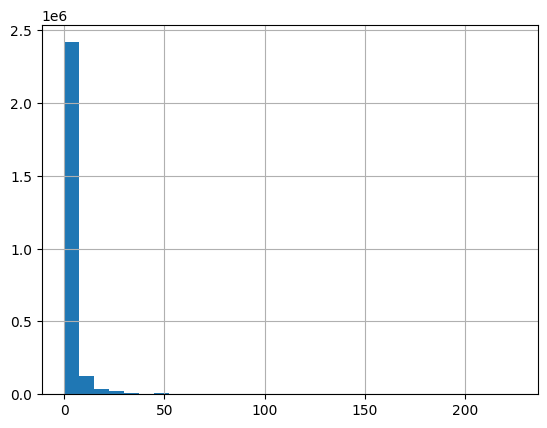

In [37]:
df.filter(df['prize_dollars']>0)['prize_dollars'].to_pandas().hist(bins=30)


c:\00 ALL\04 Jobs\22 Voodoo\visualizations.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col_name, y='count', data=df, palette='viridis')


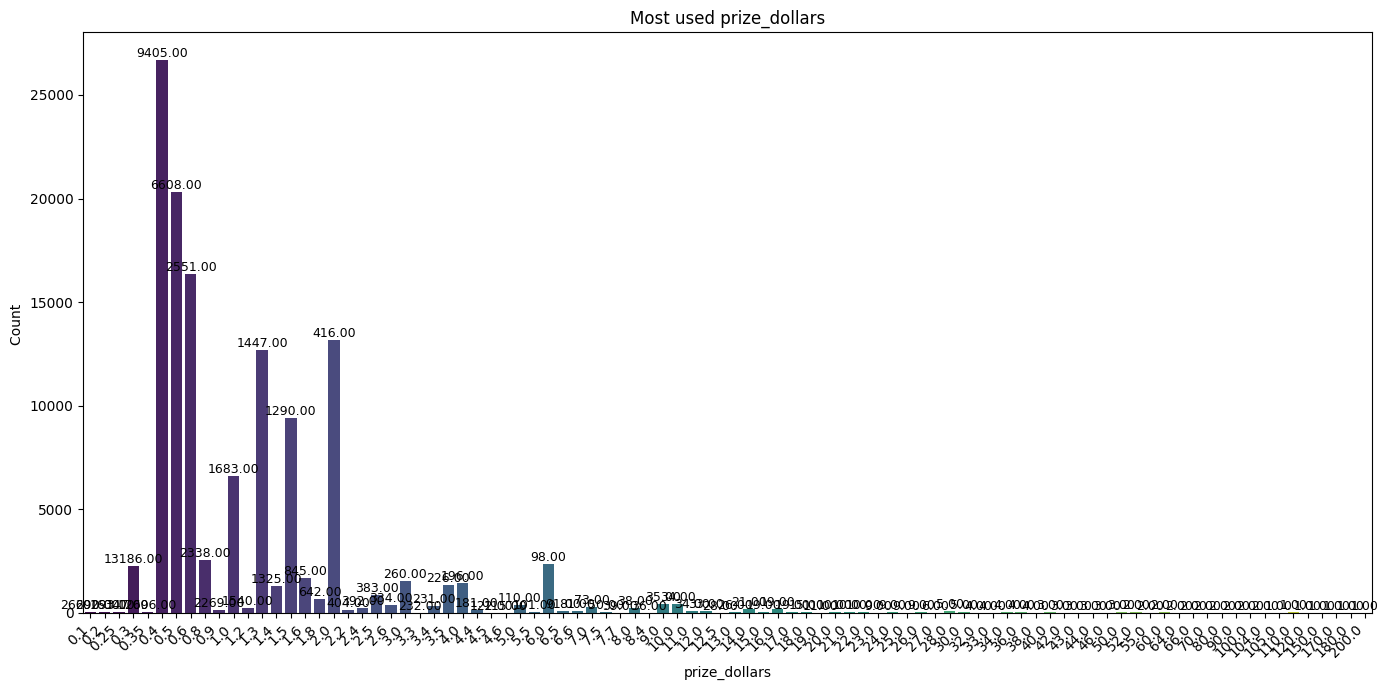

In [38]:
af = (df.filter(df['prize_dollars'] > 0)
   .group_by('user_id')
   .agg(pl.col('prize_dollars').mode().alias('mode_prices'))
   .explode('mode_prices')
   .rename({'mode_prices': 'prize_dollars'}))
af.head(9)

game_counts = af.group_by('prize_dollars').len().to_pandas()
histo(game_counts,'prize_dollars', title='Most used prize_dollars',symbol='D')


#### Prize_coins

<Axes: >

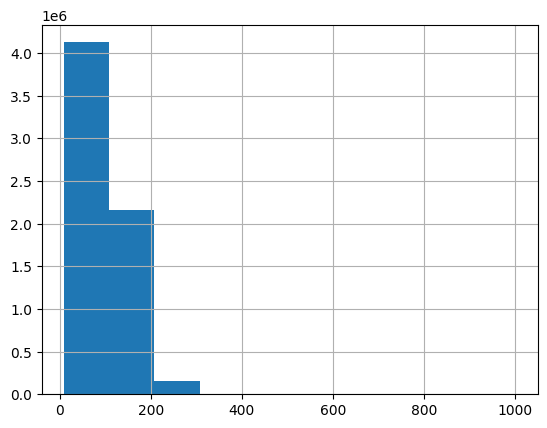

In [39]:
df.filter(df['prize_coins']>0)['prize_coins'].to_pandas().hist(bins=10)


c:\00 ALL\04 Jobs\22 Voodoo\visualizations.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col_name, y='count', data=df, palette='viridis')


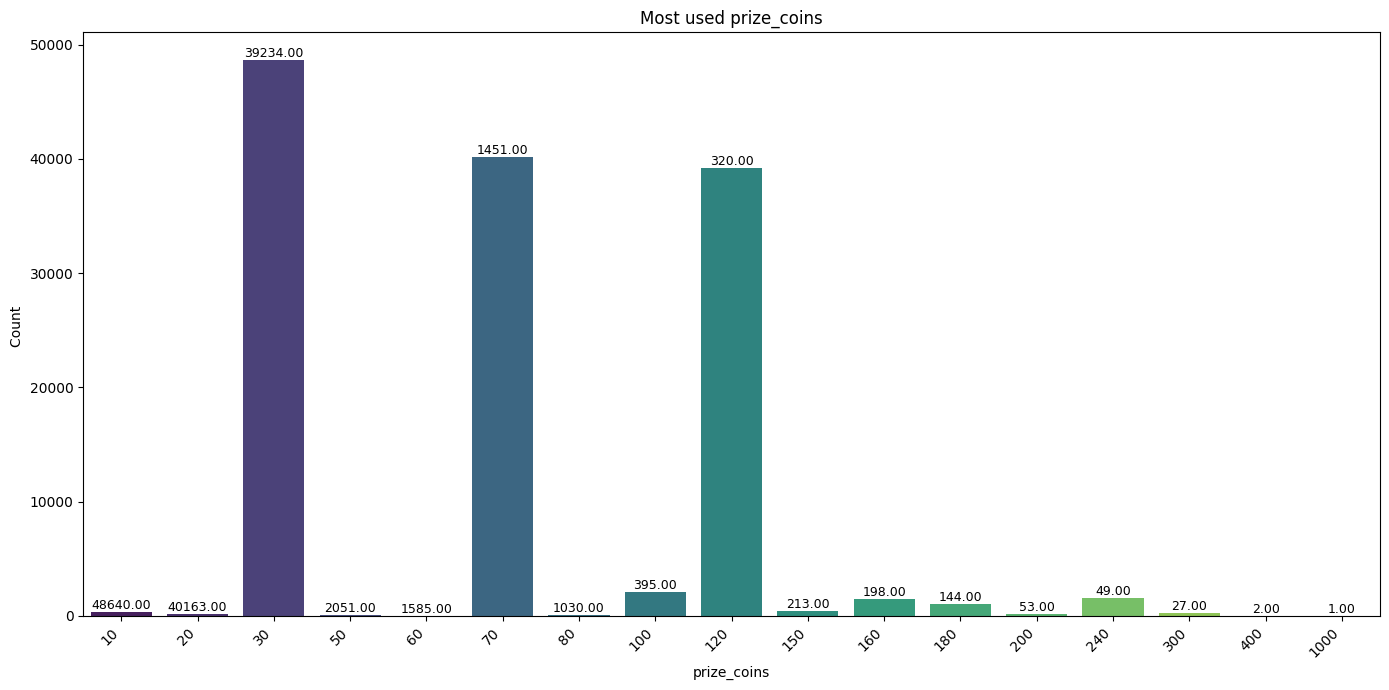

In [40]:
af = (df.filter(df['prize_coins'] > 0)
   .group_by('user_id')
   .agg(pl.col('prize_coins').mode().alias('mode_prices'))
   .explode('mode_prices')
   .rename({'mode_prices': 'prize_coins'}))
af.head(9)

game_counts = af.group_by('prize_coins').len().to_pandas()
histo(game_counts,'prize_coins', title='Most used prize_coins',symbol='D')


#### Total_players

<Axes: >

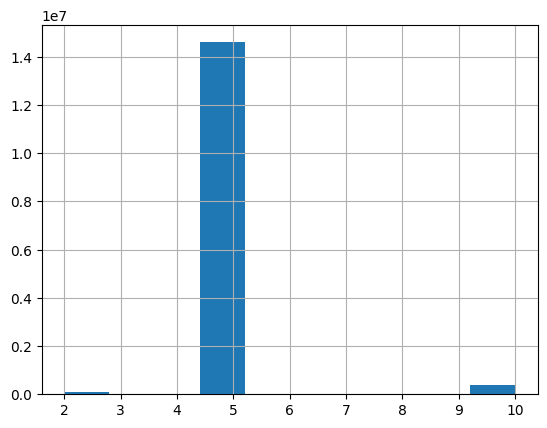

In [41]:
df.filter(df['total_players']>0)['total_players'].to_pandas().hist(bins=10)


---
## Adhoc Questions

### 1. When does a user start putting real money? (first dollar entry_credit_type)

In [42]:
#order
sorted_df = df.sort(["user_id", "started_at"], descending=[False, False])
sorted_df = sorted_df.with_columns(
    pl.when(pl.col("seconds_until_result") > 0)
      .then(1)
      .otherwise(0)
      .alias("is_completed"),
)


In [43]:
sorted_df = sorted_df.with_columns(
   pl.col('is_completed')
      .cum_sum()
      .over(['user_id'])
      .alias("game_number")
 )

sorted_df = sorted_df.with_columns(
    pl.when((pl.col("is_completed") == 1) & (pl.col("entry_credit_type") == "DOLLAR"))
    .then(1)
    .otherwise(0)
    .alias("completed_dollar_game")
)

first_dollar_games = (
    sorted_df
    .filter(pl.col("completed_dollar_game") == 1)
    .group_by("user_id")
    .agg(pl.min("game_number").alias("first_dollar_game_number"))
)
 
sorted_df = sorted_df.join(
    first_dollar_games,
    on="user_id",
    how="left"
)

# adding day difference
sorted_df = sorted_df.with_columns(
    pl.col("started_at") 
    .min()
    .over("user_id")
    .alias("first_game_date")
)


sorted_df = sorted_df.with_columns(
    (pl.col("started_at") - pl.col("first_game_date"))
    .dt.total_days()
    .floor()
    .cast(pl.Int64).alias("days_since_first_game")
)

  

In [44]:
# proof first_dollar_game_number works well
# user = 'JbAAfDVPSIdl0Xjr5lCk6V7A7nr1'
# sorted_df.filter(sorted_df['user_id'] == user).tail(30)

In [45]:
# How many days per user until played a DOLLAR entry credit type game
first_dollar_game_number_per_user = sorted_df.group_by('user_id')\
    .agg(pl.col('first_dollar_game_number')
    .min())
first_dollar_game_number_per_user.head(3)


user_id,first_dollar_game_number
str,i32
"""000IdEMSNCZrJrP5KI7P1JhpLuy2""",null
"""000eyKdzIUPjGcFzby3nS93Fehq2""",1
"""0017fygxbAZdmCma7tH3TrcXlpz2""",null


array([[<Axes: title={'center': 'first_dollar_game_number'}>]],
      dtype=object)

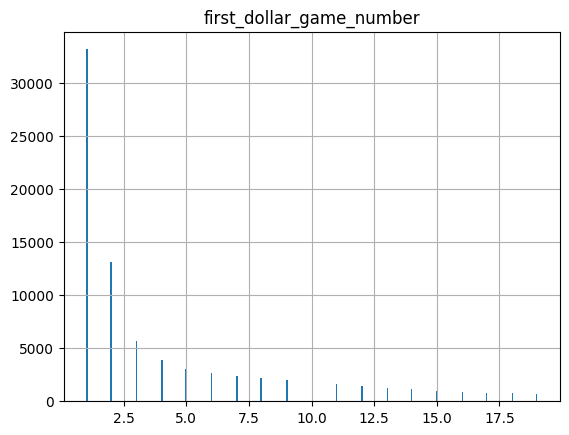

In [46]:
#show only non null users with less than 20 days
first_dollar_game_number_per_user.filter(\
  (~first_dollar_game_number_per_user['first_dollar_game_number'].is_null())\
    & (first_dollar_game_number_per_user['first_dollar_game_number'] <20))\
      .to_pandas().hist(bins=300)

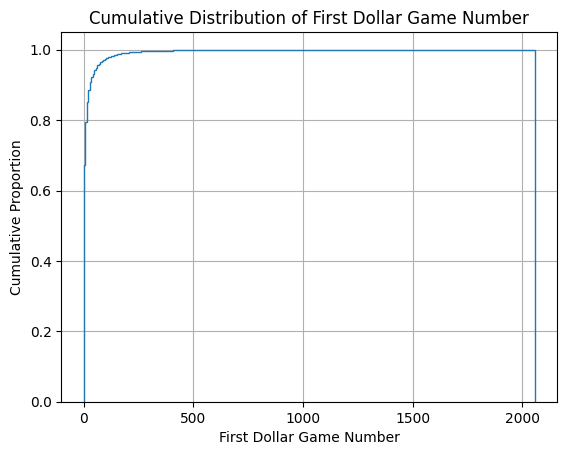

In [47]:
#show only non null users with cumulatative curb

filtered = first_dollar_game_number_per_user.filter(
    (~first_dollar_game_number_per_user['first_dollar_game_number'].is_null()) 

).to_pandas()


filtered['first_dollar_game_number'].hist(
    bins=300, 
    cumulative=True, 
    density=True,
    histtype='step'
)
plt.xlabel('First Dollar Game Number')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Distribution of First Dollar Game Number')
plt.show()

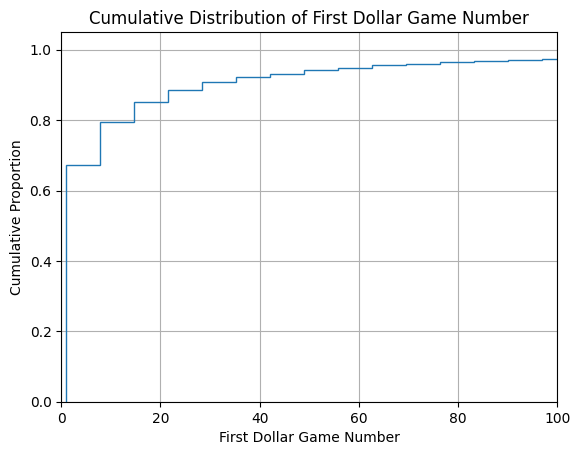

In [48]:
# Make a zoom to 100 max games
filtered = first_dollar_game_number_per_user.filter(
    (~first_dollar_game_number_per_user['first_dollar_game_number'].is_null()) 

).to_pandas()


filtered['first_dollar_game_number'].hist(
    bins=300, 
    cumulative=True, 
    density=True,
    histtype='step'
)
plt.xlabel('First Dollar Game Number')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Distribution of First Dollar Game Number')
# For Zoom
plt.xlim(0, 100)


plt.show()

> If the users are going to become dollar gamblers, 40 games should be enough for the majority.

### 2. How many days does this represents on avg? 

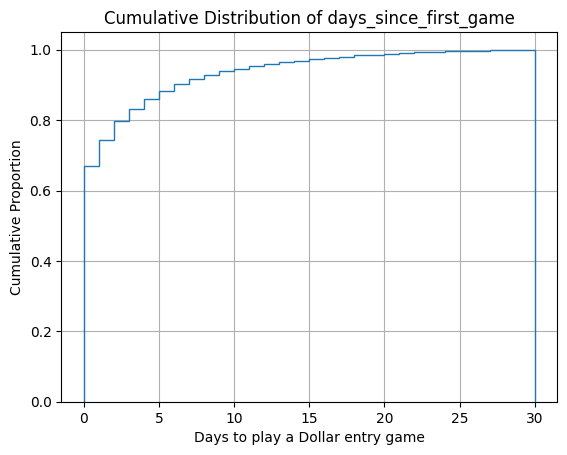

In [49]:
# Get the day when they started playing with Dollars since first day played.
days_since_first_game_per_user = sorted_df\
    .filter(sorted_df['game_number'] == sorted_df['first_dollar_game_number'])\
        .group_by('user_id')\
            .agg(pl.col('days_since_first_game')\
                .min())
aux = days_since_first_game_per_user.to_pandas()

aux['days_since_first_game'].hist(
    bins=300, 
    cumulative=True, 
    density=True,
    histtype='step'
)
plt.xlabel('Days to play a Dollar entry game')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Distribution of days_since_first_game')
plt.show()


> By day 5 most users will already be playing a Dollar game, and by day 20 almost everyone (this is due to our constrains in data, check next result).

> We will use these features (first_dollar_game_number_per_user and days_since_first_game_per_user ) in Feature Engineering.

### 3. What is the seniority in our data?

array([[<Axes: title={'center': 'days_since_first_game'}>]], dtype=object)

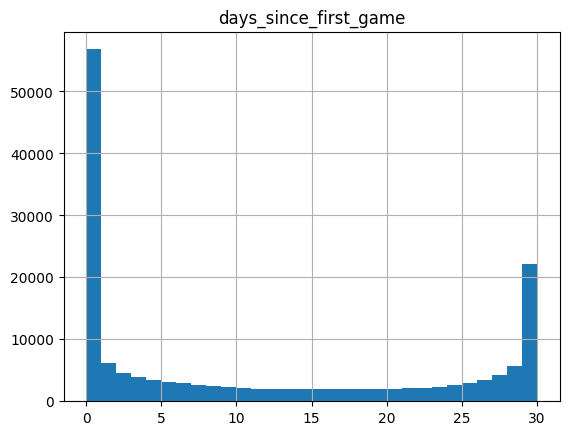

In [50]:
#Label Seniority (days_since_first_game)
min_start_date =  df.group_by(['user_id']).agg(pl.col('started_at').min().alias('min_start_at'))
af = df.join(min_start_date, on='user_id', how='left')
af = af.with_columns((pl.col("started_at") - pl.col("min_start_at")).dt.total_days().alias("days_since_first_game"))

af.group_by('user_id').agg(pl.col('days_since_first_game').max()).to_pandas().hist(bins=30)



In [51]:
df['started_at'].min(), df['started_at'].max()

(datetime.datetime(2023, 12, 1, 0, 0),
 datetime.datetime(2023, 12, 31, 23, 59, 59))

---
# 3) Feature Engineering


**Objective:**\
The segmentation aims to study users monetization behavior. \

Meaning: we want to know the __**behaviours**__ that relates users that use DOLLARS ('PAYERS') \
and the opposite behavior, the NON PAYERS. This will give insights on the actions that can take for converting Non-Payers to Payers.

**TO DO:**
1) Mark players who had and had NOT betted at least one game (Label: payers / non-payers  )
1) Mark players who probably didnt have enough time to bet (30 days) and take them out of the study (Label: 30Days_to_play).
1) Create Dummies, for later usage.
1) Summarize per user, in one row, as much knowledge on behaviour that we can from the data we posses (feature engineering).
1) Convert to pandas for pre-processing.

**Expected outcome:**  features_df


In [52]:
df.head(3)

user_id,game_id,match_type,entry_credit_type,entry_price_dollars,entry_price_coins,prize_dollars,prize_coins,started_at,total_players,match_rank,seconds_until_result
str,str,str,str,f64,i64,f64,i32,datetime[ns],i32,i64,i64
"""grljjnB0W3TeQF4zbmYSgK8fje73""","""Domino""","""BRAWL""","""DOLLAR""",0.6,300,0.0,null,2023-12-01 06:16:42,5,4,1256
"""i1bSrM2dhIQdnKkKRSi3SBF9PMS2""","""21Blitz""","""BRAWL""","""COIN""",null,50,null,120,2023-12-01 06:16:51,5,1,7753
"""ycv5gjeeA0OuzoSsToa2WEkYn3z2""","""Match3""","""BRAWL""","""COIN""",null,50,null,0,2023-12-01 06:16:58,5,4,109


#### a) Label: payers / non-payers classification

In [53]:
is_payer_table = df.join(first_dollar_game_number_per_user, on="user_id", how="left")

is_payer_table = is_payer_table.with_columns(
    pl.when(pl.col("first_dollar_game_number")>0)
    .then(1)
    .otherwise(0)
    .alias("is_payer")
)

is_payer_table = (
    is_payer_table.group_by("user_id")\
        .agg( pl.col("is_payer").max().alias("is_payer"))
    )

# Ensure no duplicates
assert is_payer_table.filter(is_payer_table['user_id'].is_duplicated()).shape[0] == 0

is_payer_table.head(2)

user_id,is_payer
str,i32
"""rdjufUB2LbXf232O1npphdXXPwF3""",1
"""MOIgTbVQjLdIQweKbzsJxd1JD312""",1


#### b)  Feature : 30Days_to_play

In [54]:
# BOOL Markers

#Player had enough days to become payer
DataBase_last_day = df['started_at'].max()

valid_users_30days = df.with_columns(
    pl.when(pl.col("started_at") < DataBase_last_day - pl.duration(days=30))
    .then(1)
    .otherwise(0)
    .alias("had_30Days_to_play")
)


valid_users_30days = valid_users_30days.with_columns(
    pl.col("had_30Days_to_play")\
        .max()\
        .over("user_id").alias("had_30Days_to_play")
)

valid_users_30days.head(2)

user_id,game_id,match_type,entry_credit_type,entry_price_dollars,entry_price_coins,prize_dollars,prize_coins,started_at,total_players,match_rank,seconds_until_result,had_30Days_to_play
str,str,str,str,f64,i64,f64,i32,datetime[ns],i32,i64,i64,i32
"""grljjnB0W3TeQF4zbmYSgK8fje73""","""Domino""","""BRAWL""","""DOLLAR""",0.6,300,0.0,null,2023-12-01 06:16:42,5,4,1256,1
"""i1bSrM2dhIQdnKkKRSi3SBF9PMS2""","""21Blitz""","""BRAWL""","""COIN""",null,50,null,120,2023-12-01 06:16:51,5,1,7753,1


#### c) Dummies variables

We want to have a table for each user where we mark if it has ever been in a specific game_id, match_type and entry_credit_type.

Columns : "game_id","match_type","entry_credit_type"

**Output:** dummies_summarized (table)

In [55]:

#Select dummy cols
cols_to_dummy = ["game_id","match_type","entry_credit_type"]

# Create all dummies
all_dummies = df.to_dummies(cs.by_name(cols_to_dummy))

#list of cols to keep
cols_to_keep = ['user_id']
for col in cols_to_dummy:
  cols_to_keep = cols_to_keep +[ col+"_"+dummy_col for dummy_col in df[col].unique().to_list()]


#keep only necessary
all_dummies = all_dummies[cols_to_keep]

# Ensure all dummies are present
assert len( df['game_id'].unique().to_list() + df['match_type'].unique().to_list() + df['entry_credit_type'].unique().to_list() + ['user_id']) == len(all_dummies.columns)


#create base table for summarizing dummies (this will)
dummies_summarized = all_dummies.select(["user_id"]).unique()

for col in list(set(cols_to_keep) - set(['user_id'])):
  result = all_dummies.group_by("user_id")\
    .agg(\
       pl.col(col).max().alias("has_done_"+col)
       )
  dummies_summarized = dummies_summarized.join(result, on="user_id", how="left")


# Ensure no duplicates
assert dummies_summarized.filter(dummies_summarized['user_id'].is_duplicated()).shape[0] == 0

dummies_summarized.head(2)

user_id,has_done_match_type_BRAWL,has_done_entry_credit_type_DOLLAR,has_done_game_id_21Blitz,has_done_game_id_Pool,has_done_game_id_Match3,has_done_game_id_BallBlast,has_done_game_id_Bingo,has_done_game_id_BubbleShooter,has_done_game_id_GinRummy,has_done_match_type_SPIN_AND_GO,has_done_game_id_KlondikeSolitaire,has_done_game_id_GridBlocks,has_done_game_id_Golf,has_done_game_id_FindObjects,has_done_entry_credit_type_COIN,has_done_match_type_ONE_VS_ONE,has_done_game_id_TripeaksSolitaire,has_done_game_id_Yatzy,has_done_game_id_TileMatch,has_done_game_id_Domino,has_done_game_id_WheelOfFortune,has_done_game_id_PokerBlast
str,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
"""EqDE0Zn8OieQvc3WJrdl3uloC4c2""",1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
"""jfZi5chg1LgIxoF8RPKPL667ga43""",1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0


In [56]:
# ## Test  >>> OK 
# m1 = df['user_id']== 'y12WV4WQ0NeIAP7uCV4ubYrGpI42'

# df.filter(m1)

#### d) Seniority (days_since_first_game) 
This could be used as filter

In [57]:
#Label Seniority (days_since_first_game)
min_start_date =  df.group_by(['user_id']).agg(pl.col('started_at').min().alias('min_start_at'))
base_df = df.join(min_start_date, on='user_id', how='left')
base_df = base_df.with_columns((pl.col("started_at") - pl.col("min_start_at")).dt.total_days().alias("days_since_first_game"))

base_df.tail(2)

user_id,game_id,match_type,entry_credit_type,entry_price_dollars,entry_price_coins,prize_dollars,prize_coins,started_at,total_players,match_rank,seconds_until_result,min_start_at,days_since_first_game
str,str,str,str,f64,i64,f64,i32,datetime[ns],i32,i64,i64,datetime[ns],i64
"""IIwwsWbUp3hKu5n9yPwWr2mdl912""","""KlondikeSolitaire""","""BRAWL""","""COIN""",null,50,null,30,2023-12-31 21:44:31,5,3,153,2023-12-01 11:39:25,30
"""4s0OYjRQ8GcAt2YfoXr0gVQyiiM2""","""TripeaksSolitaire""","""BRAWL""","""COIN""",null,50,null,0,2023-12-31 21:44:39,5,4,397,2023-12-01 18:10:54,30


#### e) User Behavior Features
 Here we add all the BEHAVIORAL features we can use.

In [58]:
# Label games completed

base_df = base_df.with_columns(
    pl.when(pl.col("seconds_until_result") > 0)
      .then(1)
      .otherwise(0)
      .alias("game_is_completed"))
base_df.head(2)



user_id,game_id,match_type,entry_credit_type,entry_price_dollars,entry_price_coins,prize_dollars,prize_coins,started_at,total_players,match_rank,seconds_until_result,min_start_at,days_since_first_game,game_is_completed
str,str,str,str,f64,i64,f64,i32,datetime[ns],i32,i64,i64,datetime[ns],i64,i32
"""grljjnB0W3TeQF4zbmYSgK8fje73""","""Domino""","""BRAWL""","""DOLLAR""",0.6,300,0.0,null,2023-12-01 06:16:42,5,4,1256,2023-12-01 00:10:25,0,1
"""i1bSrM2dhIQdnKkKRSi3SBF9PMS2""","""21Blitz""","""BRAWL""","""COIN""",null,50,null,120,2023-12-01 06:16:51,5,1,7753,2023-12-01 06:14:01,0,1


In [59]:
# base_df = base_df.filter(base_df['days_since_first_game'] < 10)

user_behavior_features = (
    base_df.group_by("user_id").agg(
        
        # --- Seniority ---
        pl.col("days_since_first_game").max().alias("seniority_in_days"),

        # --- Game Usage ---
        pl.col("game_is_completed").sum().alias("total_played_games"),
        pl.col("seconds_until_result").mean().alias("avg_game_duration"),
        pl.col("seconds_until_result").std().alias("game_duration_std"),
        pl.col("game_id").mode().first().alias("most_played_game_id"),
        pl.col("match_type").mode().first().alias("most_played_match_type"),
        # --- Spending Metrics ---
        ## Dollars
        pl.col("entry_price_dollars").mean().alias("avg_entry_dollars"), # <-- Remake
        pl.col("entry_price_dollars").sum().alias("total_spend_dollars"),
        pl.col("entry_price_dollars").std().alias("spend_dollars_std"), # <--- Remake
        pl.col("prize_dollars").sum().alias("total_prize_dollars"),
        
        ## Coins
        pl.col("entry_price_coins").mean().alias("avg_entry_coins"),
        pl.col("entry_price_coins").sum().alias("total_spend_coins"),
        pl.col("entry_price_coins").std().alias("spend_coins_std"),
        pl.col("prize_coins").sum().alias("total_prize_coins"),

        # --- Game Outcome ---
        pl.len().alias("match_count"),
        pl.col("match_rank").mean().alias("avg_rank"),
        pl.col("match_rank").min().alias("best_rank"),
        pl.col("match_rank").max().alias("worst_rank"),

        # --- Time Patterns ---
        pl.col("started_at").dt.hour().mode().first().alias("most_played_hour"),
        (pl.col("started_at").dt.hour().is_between(0, 5)).mean().alias("night_matches"),
        (pl.col("started_at").dt.hour().is_between(6, 11)).mean().alias("morning_matches"),
        (pl.col("started_at").dt.hour().is_between(12, 17)).mean().alias("afternoon_matches"),
        (pl.col("started_at").dt.hour().is_between(18, 23)).mean().alias("evening_matches"),
        pl.col("started_at").dt.weekday().mode().first().alias("most_played_weekday"),
        (pl.col("started_at").dt.weekday().is_in([0, 1, 2, 3, 4])).mean().alias("weekday_user"),
        (pl.col("started_at").dt.weekday().is_in([5, 6])).mean().alias("weekend_user"),

        # --- Player Metrics ---
        pl.col("total_players").mean().alias("avg_players_per_match"),

        # --- Win Metrics ---
        (pl.col("match_rank") == 1).sum().alias("first_place_count"),
        (pl.col("match_rank") <= 3).sum().alias("top_three_count"),
        (pl.col("match_rank") > 3).sum().alias("loss_count"),  # Can be removed if unnecessary

        # --- Game Variety Exposure ---
        pl.col("match_type").n_unique().alias("match_type_variety_exposure"),

        # --- Paid Matches ---
        pl.col("entry_price_dollars").filter(pl.col("entry_price_dollars") > 0).count().alias("paid_match_count"),
    )
)

user_behavior_features.head(2)


user_id,seniority_in_days,total_played_games,avg_game_duration,game_duration_std,most_played_game_id,most_played_match_type,avg_entry_dollars,total_spend_dollars,spend_dollars_std,total_prize_dollars,avg_entry_coins,total_spend_coins,spend_coins_std,total_prize_coins,match_count,avg_rank,best_rank,worst_rank,most_played_hour,night_matches,morning_matches,afternoon_matches,evening_matches,most_played_weekday,weekday_user,weekend_user,avg_players_per_match,first_place_count,top_three_count,loss_count,match_type_variety_exposure,paid_match_count
str,i64,i32,f64,f64,str,str,f64,f64,f64,f64,f64,i64,f64,i32,u32,f64,i64,i64,i8,f64,f64,f64,f64,i8,f64,f64,f64,u32,u32,u32,u32,u32
"""mesN9g7bPzTbS0cBa3aTjw5VwDz1""",0,4,419.5,535.405454,"""BallBlast""","""BRAWL""",null,0.0,null,0.0,50.0,200,0.0,240,4,3.0,1,5,14,0.0,0.0,1.0,0.0,7,0.0,0.0,5.0,2,2,2,1,0
"""Obt6uvdEcUbXlZBysanpaiQxL5C3""",0,1,583.0,null,"""KlondikeSolitaire""","""BRAWL""",null,0.0,null,0.0,1000.0,1000,null,0,1,7.0,7,7,19,0.0,0.0,0.0,1.0,6,0.0,1.0,10.0,0,0,1,1,0


In [60]:
base_df = df.filter(~df['entry_price_dollars'].is_null())
avg_entry_dollars = (
    base_df
    .group_by("user_id")
    .agg(pl.col("entry_price_dollars").mean().alias("avg_entry_price"))
)

avg_entry_dollars

user_id,avg_entry_price
str,f64
"""kcRZTV15Oocg9MZmvmYq5YGmaTk1""",0.84
"""7hMwiLRmE3an5hQ4otMxoymVh0n2""",0.85
"""nfc5uM3ivuT9M9aVR4smeAizXeE2""",2.5
"""glzkgzyLWpSti0FUQpzkULm0Pz82""",3.3
"""oImRjadtL6TN1zocIHeANjX7NN72""",2.29375
…,…
"""JYGHmtubI0Q9nT9D80zU39XDnvu2""",0.6
"""ngibgcALLbeJJumvSCWl9IXaKIS2""",0.775
"""1VdBvbFLiKYljOWdcZO60aOW6r93""",2.0


#### e) Composed features (metrics)

In [61]:
user_behavior_features = user_behavior_features.with_columns([
    # Net profit/loss
    (pl.col("total_prize_dollars") - pl.col("total_spend_dollars")).alias("net_dollar_profit"),
    (pl.col("total_prize_coins") - pl.col("total_spend_coins")).alias("net_coin_profit"),
    
    # Performance metrics
    (pl.col("first_place_count") / pl.col("match_count")).alias("win_rate"),
    (pl.col("top_three_count") / pl.col("match_count")).alias("top_three_rate"),
    
    # Monetization behavior
    (pl.col("paid_match_count") / pl.col("match_count")).alias("paid_game_ratio"),
    
    #win_rate categories (low, medium, high)
    #total spend ratio (dollars/coins)

])

user_behavior_features.head(2)

user_id,seniority_in_days,total_played_games,avg_game_duration,game_duration_std,most_played_game_id,most_played_match_type,avg_entry_dollars,total_spend_dollars,spend_dollars_std,total_prize_dollars,avg_entry_coins,total_spend_coins,spend_coins_std,total_prize_coins,match_count,avg_rank,best_rank,worst_rank,most_played_hour,night_matches,morning_matches,afternoon_matches,evening_matches,most_played_weekday,weekday_user,weekend_user,avg_players_per_match,first_place_count,top_three_count,loss_count,match_type_variety_exposure,paid_match_count,net_dollar_profit,net_coin_profit,win_rate,top_three_rate,paid_game_ratio
str,i64,i32,f64,f64,str,str,f64,f64,f64,f64,f64,i64,f64,i32,u32,f64,i64,i64,i8,f64,f64,f64,f64,i8,f64,f64,f64,u32,u32,u32,u32,u32,f64,i64,f64,f64,f64
"""mesN9g7bPzTbS0cBa3aTjw5VwDz1""",0,4,419.5,535.405454,"""BallBlast""","""BRAWL""",null,0.0,null,0.0,50.0,200,0.0,240,4,3.0,1,5,14,0.0,0.0,1.0,0.0,7,0.0,0.0,5.0,2,2,2,1,0,0.0,40,0.5,0.5,0.0
"""Obt6uvdEcUbXlZBysanpaiQxL5C3""",0,1,583.0,null,"""KlondikeSolitaire""","""BRAWL""",null,0.0,null,0.0,1000.0,1000,null,0,1,7.0,7,7,19,0.0,0.0,0.0,1.0,6,0.0,1.0,10.0,0,0,1,1,0,0.0,-1000,0.0,0.0,0.0


In [62]:
cols_to_dummy =["most_played_game_id","most_played_match_type"]

# Create all dummies
usr_behavior_dummies = user_behavior_features.to_dummies(cs.by_name(cols_to_dummy))

#list of cols to keep
cols_to_keep = ['user_id']
for col in cols_to_dummy:
  cols_to_keep = cols_to_keep +[ col+"_"+dummy_col for dummy_col in user_behavior_features[col].unique().to_list()]

#keep only necessary
usr_behavior_dummies = usr_behavior_dummies[cols_to_keep]

# Ensure all dummies are present
assert len(  user_behavior_features['most_played_game_id'].unique().to_list() +\
  user_behavior_features['most_played_match_type'].unique().to_list() +\
    ['user_id']) == len(usr_behavior_dummies.columns)


#create base table for summarizing dummies (this will)
usr_dummies_summarized = usr_behavior_dummies.select(["user_id"]).unique()

for col in list(set(cols_to_keep) - set(['user_id'])):
  result = usr_behavior_dummies.group_by("user_id")\
    .agg(\
       pl.col(col).max().alias(col)
       )
  usr_dummies_summarized = usr_dummies_summarized.join(result, on="user_id", how="left")


# Ensure no duplicates
assert usr_dummies_summarized.filter(usr_dummies_summarized['user_id'].is_duplicated()).shape[0] == 0

usr_dummies_summarized.head(2)

user_id,most_played_match_type_SPIN_AND_GO,most_played_game_id_FindObjects,most_played_game_id_Yatzy,most_played_game_id_TileMatch,most_played_game_id_WheelOfFortune,most_played_game_id_BallBlast,most_played_game_id_Bingo,most_played_game_id_BubbleShooter,most_played_match_type_BRAWL,most_played_game_id_GinRummy,most_played_game_id_Golf,most_played_game_id_PokerBlast,most_played_game_id_GridBlocks,most_played_game_id_Pool,most_played_game_id_Domino,most_played_match_type_ONE_VS_ONE,most_played_game_id_TripeaksSolitaire,most_played_game_id_KlondikeSolitaire,most_played_game_id_Match3,most_played_game_id_21Blitz
str,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
"""N2F1iirps3WhiwtOQfuelytXCgj2""",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
"""ynk1XlvLU7UddLCrjL5fGGFDAjJ2""",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


### Merge user_features + user_behavior_w_dummies + is_payer_table + valid_users_30days 

In [63]:
first_dollar_game_number_per_user.head(2), days_since_first_game_per_user.head(2)

(shape: (2, 2)
 ┌──────────────────────────────┬──────────────────────────┐
 │ user_id                      ┆ first_dollar_game_number │
 │ ---                          ┆ ---                      │
 │ str                          ┆ i32                      │
 ╞══════════════════════════════╪══════════════════════════╡
 │ 000IdEMSNCZrJrP5KI7P1JhpLuy2 ┆ null                     │
 │ 000eyKdzIUPjGcFzby3nS93Fehq2 ┆ 1                        │
 └──────────────────────────────┴──────────────────────────┘,
 shape: (2, 2)
 ┌──────────────────────────────┬───────────────────────┐
 │ user_id                      ┆ days_since_first_game │
 │ ---                          ┆ ---                   │
 │ str                          ┆ i64                   │
 ╞══════════════════════════════╪═══════════════════════╡
 │ 000eyKdzIUPjGcFzby3nS93Fehq2 ┆ 0                     │
 │ 006wyBYUB6MkEs9PE73ArxiXDxw1 ┆ 0                     │
 └──────────────────────────────┴───────────────────────┘)

In [64]:
# Merge with dummies

features_df_polars = user_behavior_features.join(usr_dummies_summarized, on='user_id', how='left') 
features_df_polars = features_df_polars.drop(cols_to_dummy)

# features_df_polars = features_df_polars.join(is_payer_table, on="user_id", how="left") # this depends on given dates filter
# features_df_polars = features_df_polars.join(valid_users_30days, on="user_id", how="left") # seniority will be enough


# This tells at which game did the player used DOLLAR as entry_credit_type (NULL if has never played with dollar)
features_df_polars = features_df_polars.join(first_dollar_game_number_per_user, on="user_id", how="left")

#Tells days since first game until Dollar as entry_credit_type game.
features_df_polars = features_df_polars.join(days_since_first_game_per_user, on="user_id", how="left")

In [65]:
features_df_polars.columns

['user_id',
 'seniority_in_days',
 'total_played_games',
 'avg_game_duration',
 'game_duration_std',
 'avg_entry_dollars',
 'total_spend_dollars',
 'spend_dollars_std',
 'total_prize_dollars',
 'avg_entry_coins',
 'total_spend_coins',
 'spend_coins_std',
 'total_prize_coins',
 'match_count',
 'avg_rank',
 'best_rank',
 'worst_rank',
 'most_played_hour',
 'night_matches',
 'morning_matches',
 'afternoon_matches',
 'evening_matches',
 'most_played_weekday',
 'weekday_user',
 'weekend_user',
 'avg_players_per_match',
 'first_place_count',
 'top_three_count',
 'loss_count',
 'match_type_variety_exposure',
 'paid_match_count',
 'net_dollar_profit',
 'net_coin_profit',
 'win_rate',
 'top_three_rate',
 'paid_game_ratio',
 'most_played_match_type_SPIN_AND_GO',
 'most_played_game_id_FindObjects',
 'most_played_game_id_Yatzy',
 'most_played_game_id_TileMatch',
 'most_played_game_id_WheelOfFortune',
 'most_played_game_id_BallBlast',
 'most_played_game_id_Bingo',
 'most_played_game_id_BubbleShoote

## Check: Null values 

In [66]:
# Quick look with null value check - simplified version
cols_with_nulls = []
for col in features_df_polars.columns:
    # Count nulls directly
    null_count = features_df_polars.select(pl.col(col).is_null().sum()).item()
    has_nulls = "Yes" if null_count > 0 else "No"
    cols_with_nulls.append(col) if null_count > 0 else None
    
    # Show a few sample values without counting unique values
    try:
        sample_values = features_df_polars.select(pl.col(col)).head(5).to_series().to_list()
    except:
        sample_values = ["Error getting samples"]
    
    print(
        f"{col} {'_' * (30 - len(col))} : nulls=> {has_nulls} ({null_count}) | "
        f"sample values: {sample_values}"
    )
print(f"Columns with missing values: {cols_with_nulls}")

user_id _______________________ : nulls=> No (0) | sample values: ['mesN9g7bPzTbS0cBa3aTjw5VwDz1', 'Obt6uvdEcUbXlZBysanpaiQxL5C3', 'apbEupfhz9QOEkfhDQ6RE5g2Jnh2', 'ZWz68vtZnoTidZ0LHSxgBVMuDRw1', 'bwpzq7TKUggpmcTNssIiMyrwg9x1']
seniority_in_days _____________ : nulls=> No (0) | sample values: [0, 0, 26, 0, 7]
total_played_games ____________ : nulls=> No (0) | sample values: [4, 1, 95, 3, 18]
avg_game_duration _____________ : nulls=> No (0) | sample values: [419.5, 583.0, 419.30526315789473, 1616.3333333333333, 206.11111111111111]
game_duration_std _____________ : nulls=> Yes (18654) | sample values: [535.4054538384905, None, 723.3363167294065, 2387.2708965120264, 105.00077808613044]
avg_entry_dollars _____________ : nulls=> Yes (63227) | sample values: [None, None, 0.6736842105263158, None, None]
total_spend_dollars ___________ : nulls=> No (0) | sample values: [0.0, 0.0, 12.799999999999999, 0.0, 0.0]
spend_dollars_std _____________ : nulls=> Yes (75055) | sample values: [None, None, 0.

# 4) Pre-Processing

Now that the data has been compacted, we can switch to pandas and benefit from the libraries that work with it.

In [67]:
features_df_polars.head(2)

user_id,seniority_in_days,total_played_games,avg_game_duration,game_duration_std,avg_entry_dollars,total_spend_dollars,spend_dollars_std,total_prize_dollars,avg_entry_coins,total_spend_coins,spend_coins_std,total_prize_coins,match_count,avg_rank,best_rank,worst_rank,most_played_hour,night_matches,morning_matches,afternoon_matches,evening_matches,most_played_weekday,weekday_user,weekend_user,avg_players_per_match,first_place_count,top_three_count,loss_count,match_type_variety_exposure,paid_match_count,net_dollar_profit,net_coin_profit,win_rate,top_three_rate,paid_game_ratio,most_played_match_type_SPIN_AND_GO,most_played_game_id_FindObjects,most_played_game_id_Yatzy,most_played_game_id_TileMatch,most_played_game_id_WheelOfFortune,most_played_game_id_BallBlast,most_played_game_id_Bingo,most_played_game_id_BubbleShooter,most_played_match_type_BRAWL,most_played_game_id_GinRummy,most_played_game_id_Golf,most_played_game_id_PokerBlast,most_played_game_id_GridBlocks,most_played_game_id_Pool,most_played_game_id_Domino,most_played_match_type_ONE_VS_ONE,most_played_game_id_TripeaksSolitaire,most_played_game_id_KlondikeSolitaire,most_played_game_id_Match3,most_played_game_id_21Blitz,first_dollar_game_number,days_since_first_game
str,i64,i32,f64,f64,f64,f64,f64,f64,f64,i64,f64,i32,u32,f64,i64,i64,i8,f64,f64,f64,f64,i8,f64,f64,f64,u32,u32,u32,u32,u32,f64,i64,f64,f64,f64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i32,i64
"""mesN9g7bPzTbS0cBa3aTjw5VwDz1""",0,4,419.5,535.405454,null,0.0,null,0.0,50.0,200,0.0,240,4,3.0,1,5,14,0.0,0.0,1.0,0.0,7,0.0,0.0,5.0,2,2,2,1,0,0.0,40,0.5,0.5,0.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,null,null
"""Obt6uvdEcUbXlZBysanpaiQxL5C3""",0,1,583.0,null,null,0.0,null,0.0,1000.0,1000,null,0,1,7.0,7,7,19,0.0,0.0,0.0,1.0,6,0.0,1.0,10.0,0,0,1,1,0,0.0,-1000,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,null,null


In [68]:
features_df = features_df_polars.to_pandas()

In [69]:
features_df.columns.to_list()

['user_id',
 'seniority_in_days',
 'total_played_games',
 'avg_game_duration',
 'game_duration_std',
 'avg_entry_dollars',
 'total_spend_dollars',
 'spend_dollars_std',
 'total_prize_dollars',
 'avg_entry_coins',
 'total_spend_coins',
 'spend_coins_std',
 'total_prize_coins',
 'match_count',
 'avg_rank',
 'best_rank',
 'worst_rank',
 'most_played_hour',
 'night_matches',
 'morning_matches',
 'afternoon_matches',
 'evening_matches',
 'most_played_weekday',
 'weekday_user',
 'weekend_user',
 'avg_players_per_match',
 'first_place_count',
 'top_three_count',
 'loss_count',
 'match_type_variety_exposure',
 'paid_match_count',
 'net_dollar_profit',
 'net_coin_profit',
 'win_rate',
 'top_three_rate',
 'paid_game_ratio',
 'most_played_match_type_SPIN_AND_GO',
 'most_played_game_id_FindObjects',
 'most_played_game_id_Yatzy',
 'most_played_game_id_TileMatch',
 'most_played_game_id_WheelOfFortune',
 'most_played_game_id_BallBlast',
 'most_played_game_id_Bingo',
 'most_played_game_id_BubbleShoote

In [70]:
[x for x in features_df.columns.to_list() if x.__contains__("most_played")]

['most_played_hour',
 'most_played_weekday',
 'most_played_match_type_SPIN_AND_GO',
 'most_played_game_id_FindObjects',
 'most_played_game_id_Yatzy',
 'most_played_game_id_TileMatch',
 'most_played_game_id_WheelOfFortune',
 'most_played_game_id_BallBlast',
 'most_played_game_id_Bingo',
 'most_played_game_id_BubbleShooter',
 'most_played_match_type_BRAWL',
 'most_played_game_id_GinRummy',
 'most_played_game_id_Golf',
 'most_played_game_id_PokerBlast',
 'most_played_game_id_GridBlocks',
 'most_played_game_id_Pool',
 'most_played_game_id_Domino',
 'most_played_match_type_ONE_VS_ONE',
 'most_played_game_id_TripeaksSolitaire',
 'most_played_game_id_KlondikeSolitaire',
 'most_played_game_id_Match3',
 'most_played_game_id_21Blitz']

In [71]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158009 entries, 0 to 158008
Data columns (total 58 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   user_id                                158009 non-null  object 
 1   seniority_in_days                      158009 non-null  int64  
 2   total_played_games                     158009 non-null  int32  
 3   avg_game_duration                      158009 non-null  float64
 4   game_duration_std                      139355 non-null  float64
 5   avg_entry_dollars                      94782 non-null   float64
 6   total_spend_dollars                    158009 non-null  float64
 7   spend_dollars_std                      82954 non-null   float64
 8   total_prize_dollars                    158009 non-null  float64
 9   avg_entry_coins                        153354 non-null  float64
 10  total_spend_coins                      158009 non-null  

In [72]:
drop_col_features = [
  # irrelevant
  'user_id',
  # drop first element in category
  'afternoon_matches',
  'weekday_user',
  'most_played_game_id_Golf',
  'most_played_match_type_ONE_VS_ONE'  
  ]

features_df_dropped = features_df.drop(columns=drop_col_features)
features_df.head(2)

,user_id,seniority_in_days,total_played_games,avg_game_duration,game_duration_std,avg_entry_dollars,total_spend_dollars,spend_dollars_std,total_prize_dollars,avg_entry_coins,...,most_played_game_id_GridBlocks,most_played_game_id_Pool,most_played_game_id_Domino,most_played_match_type_ONE_VS_ONE,most_played_game_id_TripeaksSolitaire,most_played_game_id_KlondikeSolitaire,most_played_game_id_Match3,most_played_game_id_21Blitz,first_dollar_game_number,days_since_first_game
0,mesN9g7bPzTbS0cBa3aTjw5VwDz1,0,4,419.5,535.405454,NaN,0.0,NaN,0.0,50.0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,Obt6uvdEcUbXlZBysanpaiQxL5C3,0,1,583.0,NaN,NaN,0.0,NaN,0.0,1000.0,...,0,0,0,0,0,1,0,0,NaN,NaN


### Missing Values

<Axes: >

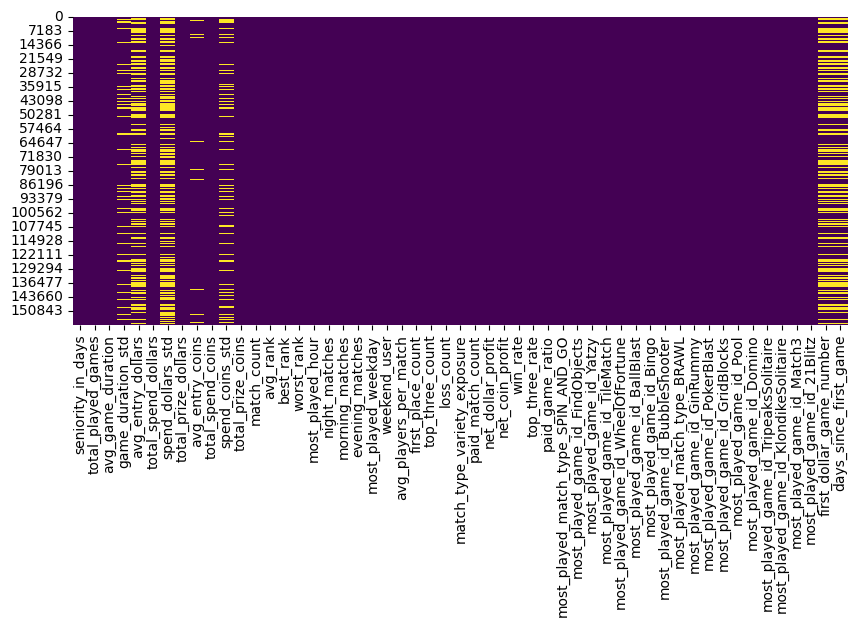

In [73]:
plt.figure(figsize=(10, 4))
sns.heatmap(features_df_dropped.isnull(), cbar=False, cmap='viridis')


In [74]:
missing_val_cols = features_df_dropped.columns[features_df_dropped.isnull().any()].to_list()
missing_val_cols

['game_duration_std',
 'avg_entry_dollars',
 'spend_dollars_std',
 'avg_entry_coins',
 'spend_coins_std',
 'first_dollar_game_number',
 'days_since_first_game']

In [75]:
for col in missing_val_cols:
  print(col, " => min = ",features_df_dropped[col].min())

game_duration_std  => min =  0.0
avg_entry_dollars  => min =  0.1999999999999997
spend_dollars_std  => min =  0.0
avg_entry_coins  => min =  15.0
spend_coins_std  => min =  0.0
first_dollar_game_number  => min =  1.0
days_since_first_game  => min =  0.0


In [76]:
fill_value = {
  'game_duration_std': 0,
 'avg_entry_dollars': 0,
 'spend_dollars_std': 0,
 'avg_entry_coins': 0,
 'spend_coins_std': 0,
 'first_dollar_game_number': 10000,
 'days_since_first_game': 10000 
}

In [77]:
features_df_dropped_filled = features_df_dropped.fillna(value=fill_value)

In [80]:
# Check Point : save to parquet
features_df_dropped_filled.to_parquet("X.parquet")

## Check Point, data is ready

In [81]:
df = features_df_dropped_filled.copy()


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158009 entries, 0 to 158008
Data columns (total 53 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   seniority_in_days                      158009 non-null  int64  
 1   total_played_games                     158009 non-null  int32  
 2   avg_game_duration                      158009 non-null  float64
 3   game_duration_std                      158009 non-null  float64
 4   avg_entry_dollars                      158009 non-null  float64
 5   total_spend_dollars                    158009 non-null  float64
 6   spend_dollars_std                      158009 non-null  float64
 7   total_prize_dollars                    158009 non-null  float64
 8   avg_entry_coins                        158009 non-null  float64
 9   total_spend_coins                      158009 non-null  int64  
 10  spend_coins_std                        158009 non-null  

In [83]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
seniority_in_days,158009.0,11.158997,11.839562,0.0,0.000000,6.000000,24.000000,30.000000
total_played_games,158009.0,95.393592,227.733900,1.0,4.000000,15.000000,78.000000,5679.000000
avg_game_duration,158009.0,1033.761713,2142.486921,7.0,358.600000,576.657895,969.722751,105280.000000
game_duration_std,158009.0,1576.245374,3288.712517,0.0,192.754507,856.919213,1478.203269,120689.692520
avg_entry_dollars,158009.0,0.927478,1.748602,0.0,0.000000,0.733333,1.122222,95.163636
total_spend_dollars,158009.0,77.441952,934.115158,0.0,0.000000,1.800000,18.200000,141200.000000
spend_dollars_std,158009.0,0.515683,1.327816,0.0,0.000000,0.000000,0.517790,60.864580
total_prize_dollars,158009.0,58.766828,796.471791,0.0,0.000000,0.500000,10.200000,134958.800000
avg_entry_coins,158009.0,248.733787,286.828208,0.0,55.066667,117.857143,300.000000,1000.000000
total_spend_coins,158009.0,6824.199634,12863.029315,0.0,1000.000000,2050.000000,7450.000000,490050.000000


In [84]:
asdfasdf

NameError: name 'asdfasdf' is not defined

# ---- Start ML PIPELINE ----

In [ ]:
# Base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pre processing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Models
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

# pipeline
from sklearn.model_selection import cross_val_score, LeaveOneOut, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV 

# Metrics, viz
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [ ]:
# Load
df = pd.read_parquet("X.parquet")

# 1) Pre-Processing

In [ ]:


# Define numeric and categorical columns
numeric_features = [
    'seniority_in_days', 'total_played_games', 'avg_game_duration', 'game_duration_std',
    'avg_entry_dollars', 'total_spend_dollars', 'spend_dollars_std', 'total_prize_dollars',
    'avg_entry_coins', 'total_spend_coins', 'spend_coins_std', 'total_prize_coins',
    'match_count', 'avg_rank', 'best_rank', 'worst_rank', 'most_played_hour',
    'night_matches', 'morning_matches', 'afternoon_matches', 'evening_matches',
    'most_played_weekday', 'weekday_user', 'weekend_user', 'avg_players_per_match',
    'first_place_count', 'top_three_count', 'loss_count', 'match_type_variety_exposure',
    'paid_match_count', 'net_dollar_profit', 'net_coin_profit', 'win_rate',
    'top_three_rate', 'paid_game_ratio'
]

categorical_features = [
    'most_played_game_id_WheelOfFortune', 'most_played_game_id_Pool',
    'most_played_game_id_PokerBlast', 'most_played_match_type_SPIN_AND_GO',
    'most_played_game_id_21Blitz', 'most_played_game_id_Yatzy',
    'most_played_game_id_Domino', 'most_played_game_id_BubbleShooter',
    'most_played_game_id_Match3', 'most_played_game_id_Golf',
    'most_played_game_id_GridBlocks', 'most_played_game_id_Bingo',
    'most_played_game_id_TripeaksSolitaire', 'most_played_match_type_ONE_VS_ONE',
    'most_played_game_id_KlondikeSolitaire', 'most_played_match_type_BRAWL',
    'most_played_game_id_FindObjects', 'most_played_game_id_TileMatch',
    'most_played_game_id_GinRummy', 'most_played_game_id_BallBlast'
]

# Numeric 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Median for skewness (by default is mean otherwise)
    ('scaler', StandardScaler())                   
])

# Categorical imputer (use most frequent value)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing cat
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Dummies
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## 1) Pipeline

In [ ]:
# Pipelines

dbscan_pipeline = Pipeline([('scaler', StandardScaler()), ('dbscan', DBSCAN())])
kmeans_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans())])
hierarchical_pipeline = Pipeline([('scaler', StandardScaler()), ('hierarchical', AgglomerativeClustering())])


In [ ]:
# Domain definition for parameter grids using RandomizedSearchCV

#NOTE: we are not interested in clustering 2 (paid vs not paid most likely)
dbscan_params = {'dbscan__eps': [0.1, 0.3, 0.5, 0.7, 1.0], 'dbscan__min_samples': [5, 10, 15, 20]}
kmeans_params = {'kmeans__n_clusters': [3, 4, 5]}
hierarchical_params = {'hierarchical__n_clusters': [ 3, 4, 5]} 

# 2) Model definition

In [ ]:
# Models instantiation

from utils import dbscan_scorer


dbscan_random_search = RandomizedSearchCV(
    dbscan_pipeline,
    dbscan_params,
    scoring=dbscan_scorer,
    cv=5,
    n_iter=10,
    random_state=42
)

# For KMeans and Hierarchical Clustering, use default scoring (Silhouette Score)
kmeans_random_search = RandomizedSearchCV(
    kmeans_pipeline,
    kmeans_params,
    scoring='silhouette_score',
    cv=5,
    n_iter=10,
    random_state=42
)

hierarchical_random_search = RandomizedSearchCV(
    hierarchical_pipeline,
    hierarchical_params,
    scoring='silhouette_score',
    cv=5,
    n_iter=10,
    random_state=42
)


# 3) Fitting models

> Please note that each model has its own pipeline and scaling is done internally

In [ ]:
dbscan_random_search.fit(df)

In [ ]:

kmeans_random_search.fit(df)


In [ ]:
hierarchical_random_search.fit(df)

In [ ]:
a# Parameter grids for Hyper tunning using RandomizedSearchCV

# We want to avoid 2 clusters as is obvious to have information between paying vs not paying users.
dbscan_params = {'dbscan__eps': [0.1, 0.5, 1.0], 'dbscan__min_samples': [5, 10, 20]}
kmeans_params = {'kmeans__n_clusters': [ 3, 4, 5]}
hierarchical_params = {'hierarchical__n_clusters': [ 3, 4, 5]} 


# Using Cross validation of 5
dbscan_random_search = RandomizedSearchCV(dbscan_pipeline, dbscan_params, cv=5, n_iter=10, random_state=42)
kmeans_random_search = RandomizedSearchCV(kmeans_pipeline, kmeans_params, cv=5, n_iter=10, random_state=42)
hierarchical_random_search = RandomizedSearchCV(hierarchical_pipeline, hierarchical_params, cv=5, n_iter=10, random_state=42)


In [ ]:
# Fit and Evaluate

# Fit models
dbscan_random_search.fit(df)
kmeans_random_search.fit(df)
hierarchical_random_search.fit(df)

# Evaluate models
dbscan_labels = dbscan_random_search.best_estimator_.named_steps['dbscan'].labels_
kmeans_labels = kmeans_random_search.best_estimator_.named_steps['kmeans'].labels_
hierarchical_labels = hierarchical_random_search.best_estimator_.named_steps['hierarchical'].labels_

# Silhouette Score
dbscan_silhouette = silhouette_score(df_scaled, dbscan_labels)
kmeans_silhouette = silhouette_score(df_scaled, kmeans_labels)
hierarchical_silhouette = silhouette_score(df_scaled, hierarchical_labels)

print(f'DBSCAN Silhouette Score: {dbscan_silhouette}')
print(f'KMeans Silhouette Score: {kmeans_silhouette}')
print(f'Hierarchical Silhouette Score: {hierarchical_silhouette}')


In [ ]:
# Check Analysis

In [ ]:


# Step 5: Feature Importance and Stability Analysis
# Feature Importance using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled)

# Feature Stability Analysis
# This is a complex topic and usually involves running the model multiple times and checking the consistency of feature importance

# Step 6: Hierarchical Clustering and Dendrogram
# Hierarchical Clustering
linked = linkage(df_scaled, 'ward')

# Plot Dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

# Step 7: t-SNE and UMAP
# t-SNE
tsne = TSNE(n_components=2)
tsne_components = tsne.fit_transform(df_scaled)

# UMAP
umap_model = umap.UMAP(n_components=2)
umap_components = umap_model.fit_transform(df_scaled)

# Plot t-SNE and UMAP
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('t-SNE')

plt.subplot(1, 2, 2)
plt.scatter(umap_components[:, 0], umap_components[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('UMAP')

plt.show()

# Step 8: Leave-One-Out Cross-Validation
# Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Example with KMeans
kmeans_loo_scores = cross_val_score(kmeans_pipeline, df, cv=loo)
print(f'KMeans LOO CV Score: {kmeans_loo_scores.mean()}')


In [ ]:

def find_optimal_eps(data, n_neighbors=5):
    """Find optimal eps parameter for DBSCAN using k-distance graph"""
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    # Sort distances in descending order
    distances = np.sort(distances[:, n_neighbors-1])[::-1]
    
    # Plot k-distance graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(distances)), distances)
    plt.xlabel('Points')
    plt.ylabel(f'Distance to {n_neighbors}th nearest neighbor')
    plt.title(f'{n_neighbors}-Distance Graph')
    
    # Find the elbow point
    from kneed import KneeLocator
    try:
        kneedle = KneeLocator(range(len(distances)), distances, 
                             curve='convex', direction='decreasing')
        eps = distances[kneedle.elbow]
        plt.axhline(y=eps, color='r', linestyle='--')
        plt.text(0, eps+0.01, f'Suggested eps: {eps:.3f}')
    except:
        eps = None
        
    plt.show()
    return eps

# Find optimal eps
optimal_eps = find_optimal_eps(df_scaled)
print(f"Suggested optimal eps value: {optimal_eps}")

# Step 3: Find optimal number of clusters for KMeans and Hierarchical using silhouette score
def find_optimal_clusters(data, max_clusters=10):
    """Find optimal number of clusters using silhouette score"""
    silhouette_scores = []
    
    # Calculate silhouette score for different numbers of clusters
    for n_clusters in range(2, max_clusters + 1):
        # KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans_labels = kmeans.fit_predict(data)
        
        # Calculate silhouette score
        score = silhouette_score(data, kmeans_labels)
        silhouette_scores.append(score)
    
    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Different Numbers of Clusters')
    plt.grid(True)
    
    # Find optimal number of clusters
    optimal_clusters = np.argmax(silhouette_scores) + 2
    plt.axvline(x=optimal_clusters, color='r', linestyle='--')
    plt.text(optimal_clusters+0.1, silhouette_scores[optimal_clusters-2]-0.01, 
             f'Optimal: {optimal_clusters}')
    
    plt.show()
    return optimal_clusters

# Find optimal number of clusters
optimal_clusters = find_optimal_clusters(df_scaled)
print(f"Optimal number of clusters: {optimal_clusters}")

# Step 4: Apply clustering algorithms with optimal parameters
# DBSCAN
dbscan = DBSCAN(eps=optimal_eps if optimal_eps else 0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)

# KMeans
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled)

# Hierarchical
hierarchical = AgglomerativeClustering(n_clusters=optimal_clusters)
hierarchical_labels = hierarchical.fit_predict(df_scaled)

# Step 5: Evaluate models using silhouette score
# Filter out noise points for DBSCAN silhouette calculation
if len(np.unique(dbscan_labels)) > 1 and -1 in dbscan_labels:
    # If there are noise points
    mask = dbscan_labels != -1
    dbscan_silhouette = silhouette_score(df_scaled[mask], dbscan_labels[mask]) if np.sum(mask) > 1 else 0
else:
    dbscan_silhouette = silhouette_score(df_scaled, dbscan_labels) if len(np.unique(dbscan_labels)) > 1 else 0

kmeans_silhouette = silhouette_score(df_scaled, kmeans_labels)
hierarchical_silhouette = silhouette_score(df_scaled, hierarchical_labels)

# Print evaluation results
print(f'DBSCAN Silhouette Score: {dbscan_silhouette:.4f}, Number of clusters: {len(np.unique(dbscan_labels[dbscan_labels != -1]))}')
print(f'KMeans Silhouette Score: {kmeans_silhouette:.4f}, Number of clusters: {len(np.unique(kmeans_labels))}')
print(f'Hierarchical Silhouette Score: {hierarchical_silhouette:.4f}, Number of clusters: {len(np.unique(hierarchical_labels))}')

# Step 6: Feature Importance using PCA
def analyze_pca_importance(data, feature_names=None):
    """Analyze feature importance using PCA"""
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(data.shape[1])]
    
    # Apply PCA
    pca = PCA()
    pca.fit(data)
    
    # Plot explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
    plt.grid(True)
    plt.show()
    
    # Calculate feature importance
    feature_importance = np.abs(pca.components_)
    
    # Create DataFrame for feature importance
    importance_df = pd.DataFrame(
        data=feature_importance[:3].T,  # Take top 3 PCs
        columns=[f'PC{i+1}' for i in range(3)],
        index=feature_names
    )
    
    # Sort by first principal component
    importance_df = importance_df.sort_values(by='PC1', ascending=False)
    
    # Plot feature importance for top PCs
    plt.figure(figsize=(12, 8))
    importance_df.head(10).plot(kind='bar', figsize=(12, 6))
    plt.title('Top 10 Feature Importance in First 3 Principal Components')
    plt.ylabel('Absolute Coefficient Magnitude')
    plt.xlabel('Features')
    plt.grid(True)
    plt.show()
    
    return importance_df

# Get feature names if available
feature_names = df.columns if isinstance(df, pd.DataFrame) else None

# Analyze feature importance
importance_df = analyze_pca_importance(df_scaled, feature_names)
print("Top 5 most important features:")
print(importance_df.head(5))

# Step 7: Visualize clusters using dimensionality reduction
def visualize_clusters(data, labels_dict, method='pca'):
    """Visualize clusters using dimensionality reduction"""
    if method.lower() == 'pca':
        reducer = PCA(n_components=2, random_state=42)
    elif method.lower() == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    # Apply dimensionality reduction
    reduced_data = reducer.fit_transform(data)
    
    # Create subplots for each clustering algorithm
    fig, axs = plt.subplots(1, len(labels_dict), figsize=(15, 5))
    
    for i, (name, labels) in enumerate(labels_dict.items()):
        # Skip if there's only one cluster
        if len(np.unique(labels)) <= 1:
            axs[i].text(0.5, 0.5, 'Only one cluster found', horizontalalignment='center')
            axs[i].set_title(name)
            continue
            
        # For DBSCAN, plot noise points differently
        if name == 'DBSCAN' and -1 in labels:
            scatter = axs[i].scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, 
                                    cmap='viridis', alpha=0.7, s=30, 
                                    edgecolors='black', linewidth=0.5)
            axs[i].set_title(f'{name} ({len(np.unique(labels[labels != -1]))} clusters + noise)')
        else:
            scatter = axs[i].scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, 
                                    cmap='viridis', alpha=0.7, s=30, 
                                    edgecolors='black', linewidth=0.5)
            axs[i].set_title(f'{name} ({len(np.unique(labels))} clusters)')
            
        axs[i].grid(True, alpha=0.3)
        
        # Add colorbar
        fig.colorbar(scatter, ax=axs[i], shrink=0.8)
    
    plt.tight_layout()
    plt.show()

# Visualize clusters
labels_dict = {
    'DBSCAN': dbscan_labels,
    'KMeans': kmeans_labels,
    'Hierarchical': hierarchical_labels
}

# PCA visualization
print("PCA Visualization:")
visualize_clusters(df_scaled, labels_dict, method='pca')

# t-SNE visualization
print("t-SNE Visualization:")
visualize_clusters(df_scaled, labels_dict, method='tsne')

# Step 8: Generate hierarchical clustering dendrogram
def plot_dendrogram(data, max_display=30):
    """Plot dendrogram for hierarchical clustering"""
    plt.figure(figsize=(12, 8))
    
    # Create linkage matrix
    linked = linkage(data, method='ward')
    
    # Plot dendrogram
    dendrogram(linked, 
              truncate_mode='lastp',
              p=max_display,
              orientation='top',
              leaf_font_size=10,
              show_contracted=True)
    
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample index or cluster size')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

# Plot dendrogram (limit to 50 samples if dataset is large)
if len(df_scaled) > 50:
    sample_indices = np.random.choice(len(df_scaled), 50, replace=False)
    plot_dendrogram(df_scaled[sample_indices])
else:
    plot_dendrogram(df_scaled)

# Step 9: Analyze cluster profiles
def analyze_cluster_profiles(data, labels, feature_names=None):
    """Analyze cluster profiles"""
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(data.shape[1])]
    
    # Convert to DataFrame
    cluster_df = pd.DataFrame(data, columns=feature_names)
    cluster_df['Cluster'] = labels
    
    # Calculate cluster statistics
    cluster_means = cluster_df.groupby('Cluster').mean()
    
    # Plot heatmap of cluster profiles
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_means, annot=False, cmap='coolwarm', center=0)
    plt.title('Cluster Profiles')
    plt.tight_layout()
    plt.show()
    
    # Bar plot of feature means by cluster
    cluster_means_long = cluster_means.reset_index().melt(id_vars=['Cluster'], 
                                                        var_name='Feature', 
                                                        value_name='Value')
    
    # Plot top 5 most discriminative features
    feature_variance = cluster_means.var(axis=0)
    top_features = feature_variance.nlargest(min(5, len(feature_variance))).index.tolist()
    
    fig, axs = plt.subplots(len(top_features), 1, figsize=(10, 3*len(top_features)))
    
    for i, feature in enumerate(top_features):
        feature_data = cluster_means_long[cluster_means_long['Feature'] == feature]
        if len(top_features) > 1:
            ax = axs[i]
        else:
            ax = axs
        sns.barplot(x='Cluster', y='Value', data=feature_data, ax=ax)
        ax.set_title(f'Mean {feature} by Cluster')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return cluster_means

# Analyze cluster profiles for the best performing algorithm
best_algorithm = max([(dbscan_silhouette, 'DBSCAN', dbscan_labels), 
                     (kmeans_silhouette, 'KMeans', kmeans_labels), 
                     (hierarchical_silhouette, 'Hierarchical', hierarchical_labels)], 
                    key=lambda x: x[0])

print(f"Best performing algorithm: {best_algorithm[1]} with silhouette score: {best_algorithm[0]:.4f}")

# For DBSCAN, remove noise points for cluster profile analysis
if best_algorithm[1] == 'DBSCAN' and -1 in best_algorithm[2]:
    mask = best_algorithm[2] != -1
    cluster_profiles = analyze_cluster_profiles(df_scaled[mask], best_algorithm[2][mask], feature_names)
else:
    cluster_profiles = analyze_cluster_profiles(df_scaled, best_algorithm[2], feature_names)

# Step 10: Summary and recommendations
print("\n=== Clustering Analysis Summary ===")
print(f"Total samples: {len(df_scaled)}")
print(f"Number of features: {df_scaled.shape[1]}")
print(f"Best algorithm: {best_algorithm[1]} with silhouette score: {best_algorithm[0]:.4f}")

if best_algorithm[1] == 'DBSCAN':
    n_clusters = len(np.unique(best_algorithm[2][best_algorithm[2] != -1]))
    n_noise = np.sum(best_algorithm[2] == -1)
    print(f"Number of clusters found: {n_clusters}")
    print(f"Number of noise points: {n_noise} ({n_noise/len(best_algorithm[2])*100:.2f}%)")
else:
    print(f"Number of clusters: {len(np.unique(best_algorithm[2]))}")

print("\nTop 5 most important features:")
for feature in importance_df.head(5).index:
    print(f"- {feature}")

print("\nRecommendations:")
print("1. Consider using the best performing algorithm for your final clustering model")
print("2. Focus on the top important features for interpretation")
print("3. Analyze the cluster profiles to understand the characteristics of each cluster")
print("4. Consider further feature engineering or selection based on PCA results")

# TODO:

In [ ]:
 CLEAN users that dont have enough time. ()


A matchmaking system needs to:

1. Represent users behaviors as structured data
1. Find suitable matches based on similarity or compatibility rules
1. Have a ranking system for potential matches according to relevance (previous point)
1. Be Scalable, meaning it must be able to handle many users and frequent updates. 

Possible systems:


1)  vector embeded system: Vector databases are high-dimensional vectors (numerical representations) and allow for similarity searches, they rely on space as data is translated to vectors.

Problems:
- Balancing factors: This is hard part as you need to weight space.
- Interpretability: They are less straight foward on how the decision was taken.
- Cold start problem: With no data, creating a meaningful vectors initially would need a strategy to handle this.

---
---
---
# BROULILLON

In [ ]:

df.filter(df['user_id'] == 'Xbkcq0zL9hbwILnFpTSfO5Zd9jm2').sort(by=['started_at'])

In [ ]:
user = 'Xbkcq0zL9hbwILnFpTSfO5Zd9jm2'
df.filter(df['user_id'] == user) ['started_at'].min(),df.filter(df['user_id'] == user) ['started_at'].max()

In [ ]:
a = pl.DataFrame({
    "A": [1, 2, 3],
    "B": [4, 5, 6],
    "C": [7, 8, 9],
    "D": [10, 11, 12]
})

# Drop a single column
a_drop_one = a.drop("A")

a_drop_one

In [ ]:
user = 'MSbZOoNmOjOh66YfWxUJIRg5N472'
avg_entry_dollars.filter(avg_entry_dollars['user_id']== user)

In [ ]:
 
base_df.filter(base_df['user_id']== user)

In [ ]:
print(base_df.filter(base_df['user_id']== 'MSbZOoNmOjOh66YfWxUJIRg5N472')['entry_price_dollars'])

In [ ]:
a = base_df.group_by('user_id').agg(pl.col('entry_price_dollars').mean(ignore_nulls=True).alias("hehe"))

print(a.filter(a['user_id']== 'MSbZOoNmOjOh66YfWxUJIRg5N472'))

In [ ]:
 base_df.group_by('user_id').agg(
    pl.col('entry_price_dollars').cast(pl.Float64).mean().alias("hehe")
)

In [ ]:
df.filter((~pl.col("entry_price_dollars").is_null()))

In [ ]:
df.group_by('user_id').agg(pl.col('entry_price_dollars').mean().alias('hehe'))

In [ ]:
features_df_polars.filter(features_df_polars['days_since_first_game'].is_null())

In [ ]:
user = 'AZS8QiEZAYRDlaKb86yXIuP8XgU2'
df.filter(df['user_id']== user)

In [ ]:

df.filter(df['user_id']== user)['seconds_until_result'].std()